In [1]:
%%HTML
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

## (2020/09/03 1:12 Yuzurihara added Japanese comment)

In [1]:
import PySimpleGUI as sg    
from pykat import finesse
from pykat.commands import * 
import pykat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
import math

sg.theme('Default1')

def collapse(layout, key):
    """
    Helper function that creates a Column that can be later made hidden, thus appearing "collapsed"
    :param layout: The layout for the section
    :param key: Key used to make this seciton visible / invisible
    :return: A pinned column that can be placed directly into your layout
    :rtype: sg.pin
    """
    return sg.pin(sg.Column(layout, key=key))

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
def generate_kat_FPMI(dic_ispds, dic_advanced_setting):

    ##############################
    ### get variables from GUI ###
    ##############################

    ### Extra Settings ###
    laser_power = dic_advanced_setting["laser_power"]#source laser power
    
    ### DoF ###
    #
    # (yuzu) pick up DoF (CARM / DARM / BS) from GUI
    # 
    dof = dic_advanced_setting["dof"]#CARM DARM BS
    
    ### sweep_power/sweep_demod_1/transferfunction_power/transferfunction_demod_2 ###
    type_of_pd_signal = dic_advanced_setting["type_of_pd_signal"]#(sweep_mode)

    ### xaxis/yaxis setting ###
    x_plotscale = dic_advanced_setting["x_plotscale"]#str
    xaxis_range_beg = dic_advanced_setting["xaxis_range_beg"]#str
    xaxis_range_end = dic_advanced_setting["xaxis_range_end"]#str
    y_plotscale = dic_advanced_setting["y_plotscale"]#str
    if x_plotscale=='linear':
        x_plotscale = 'lin'
    if y_plotscale=='linear':
        y_plotscale = 'lin'
    samplingnum = dic_advanced_setting["samplingnum"]

    ### pd1 advanced setting/pd2 advanced setting ###
    pd1_demod_phase = dic_advanced_setting["pd1_demod_phase"]#str
    pd1_demodfreq = dic_advanced_setting["pd1_demodfreq"]#str
    pd2_demod_phase = dic_advanced_setting["pd2_demod_phase"]#str
    pd2_mixer1_demodfreq = dic_advanced_setting["pd2_mixer1_demodfreq"]#str
    #
    # default demod_phase, demod_freque is Pd1's configuration
    #
    demod_phase = dic_advanced_setting["pd1_demod_phase"]#str
    demod_freq = dic_advanced_setting["pd1_demodfreq"]#str
    if(type_of_pd_signal=="transferfunction_demod_2"):
        demod_phase  = dic_advanced_setting["pd2_demod_phase"]#str
        demod_freq = dic_advanced_setting["pd2_mixer1_demodfreq"]#str
    #
    # demod_phase_I,demod_phase_Q must define after demod_phase is defined
    #
    demod_phase_I = str(0+float(demod_phase))#str
    demod_phase_Q = str(90+float(demod_phase))#str

    ######################
    ### INF components ###
    ######################
    #
    # Prepare common (fixed for KAGRA) setting for kat file 
    # 
    input_finesse = """
    
### FPMI

const f1_SB 16.881M
const f2_SB 45.0159M

# Input optics
l i1 %s 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.99995 5e-06 90 ny3 nTMSY

    """ % (laser_power)

    ### PDs location ###
    pd0s_code = ""
    pd1s_code = ""
    pd2s_code = ""

    for key in dic_ispds.keys():
        if dic_ispds[key] == True:
            if(type_of_pd_signal=="sweep_power" or type_of_pd_signal=="transferfunction_power"):
                pd0s_code_add = """
pd0 pd0_%s %s
                """% (key,key,
                    )
                input_finesse = input_finesse + pd0s_code_add # input finesse ni tyokusetu tasu

            if(type_of_pd_signal=="sweep_demod_1"):
                pd1s_code_add = """
pd1 pd1_I1_%s $f1_SB %s %s
pd1 pd1_Q1_%s $f1_SB %s %s
pd1 pd1_I2_%s $f2_SB %s %s
pd1 pd1_Q2_%s $f2_SB %s %s
pd1 pd1_IX_%s %s %s %s
pd1 pd1_QX_%s %s %s %s
                """% (key, demod_phase_I, key,
                    key, demod_phase_Q, key,
                    key, demod_phase_I, key,
                    key, demod_phase_Q, key,
                    key, demod_freq, demod_phase_I, key,
                    key, demod_freq, demod_phase_Q, key
                    )
                input_finesse = input_finesse + pd1s_code_add
            if(type_of_pd_signal=="transferfunction_demod_2"):
                pd2s_code_add ="""
pd2 pd2_I1_%s $f1_SB %s 10 %s
put pd2_I1_%s f2 $x1
pd2 pd2_Q1_%s $f1_SB %s 10 %s
put pd2_Q1_%s f2 $x1

pd2 pd2_I2_%s $f2_SB %s 10 %s
put pd2_I2_%s f2 $x1
pd2 pd2_Q2_%s $f2_SB %s 10 %s
put pd2_Q2_%s f2 $x1

pd2 pd2_IX_%s %s %s 10 %s
put pd2_IX_%s f2 $x1
pd2 pd2_QX_%s %s %s 10 %s
put pd2_QX_%s f2 $x1
                """% (key, demod_phase_I, key,
                    key,
                    key, demod_phase_Q, key,
                    key,
                    key, demod_phase_I, key,
                    key,
                    key, demod_phase_Q, key,
                    key,
                    key, demod_freq, demod_phase_I, key,
                    key,
                    key, demod_freq, demod_phase_Q, key,
                    key
                    )
                input_finesse = input_finesse + pd2s_code_add

    ### sweep ###
    if(type_of_pd_signal=="sweep_power" or type_of_pd_signal=="sweep_demod_1"):
        ### DoF ###
        if(dof=="DARM"):
            darm_sweep = """
# DARM scan
xaxis ETMX phi %s %s %s %s
put* ETMY phi $mx1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
            input_finesse = input_finesse + darm_sweep

        elif(dof=="CARM"):
            carm_sweep = """
# CARM scan
#(koyama) xaxis*
#initial
# m ITMX 0.996 0.004 0 nx1 nx2
xaxis ETMX phi %s %s %s %s
put* ETMY phi $x1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
            input_finesse = input_finesse + carm_sweep

        elif(dof=="BS"):
            bs_sweep = """
# BS scan
#
#(koyama) original vergion og kokeyamasan uses xaxis*
# select xaxis plotscale "log" cause an error with xaxis*
# m ITMX 0.996 0.004 0 nx1 nx2 
# since the config are above, I think it doesnt cause any problem about the correctness of the result
# 

xaxis ITMX phi %s %s %s %s
put* ITMY phi $mx1
put* ETMX phi $x1
put* ETMY phi $mx1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
            input_finesse = input_finesse + bs_sweep
        else:
            pass
    ### transfer function ###
    if(type_of_pd_signal=="transferfunction_power" or type_of_pd_signal=="transferfunction_demod_2"):   
        ### DoF ###
        if(dof=="DARM"):
            darm_sweep = """
## DARM ###
fsig sig1 ETMX 10 0
fsig sig1 ETMY 10 180
xaxis sig1 f %s %s %s %s
yaxis lin abs:deg
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
            input_finesse = input_finesse + darm_sweep

        elif(dof=="CARM"):
            carm_sweep = """
## CARM ###
fsig sig1 ETMX 10 0
fsig sig1 ETMY 10 0
xaxis sig1 f %s %s %s %s
yaxis lin abs:deg
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
            input_finesse = input_finesse + carm_sweep

        elif(dof=="BS"):
            bs_sweep = """
## BS ###
fsig sig1 ETMX 10 0
fsig sig1 ITMX 10 0
fsig sig1 ETMY 10 180
fsig sig1 ITMY 10 180
xaxis sig1 f %s %s %s %s
yaxis lin abs
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
            input_finesse = input_finesse + bs_sweep
        else:
            pass

    code = input_finesse
    print(code)
    return code

sweep_power
k_inf_f_n1
k_inf_f_n4
k_inf_f_nTMSY
k_inf_f_nTMSX
k_inf_f_n2
k_inf_f_n3
k_inf_f_ny1
k_inf_f_nx1
k_inf_f_ny2
k_inf_f_nx2
k_inf_f_ny3
k_inf_f_nx3
k_inf_c_n1
k_inf_c_n4
k_inf_c_nTMSY
k_inf_c_nTMSX
k_inf_c_n2
k_inf_c_n3
k_inf_c_ny1
k_inf_c_nx1
k_inf_c_ny2
k_inf_c_nx2
k_inf_c_ny3
k_inf_c_nx3
['k_inf_f_n1', 'k_inf_f_n4', 'k_inf_f_nTMSY', 'k_inf_f_nTMSX', 'k_inf_f_n2', 'k_inf_f_n3', 'k_inf_f_ny1', 'k_inf_f_nx1', 'k_inf_f_ny2', 'k_inf_f_nx2', 'k_inf_f_ny3', 'k_inf_f_nx3']
['k_inf_f_n1', 'k_inf_f_n4', 'k_inf_f_nTMSY', 'k_inf_f_nTMSX']

    
### FPMI

const f1_SB 16.881M
const f2_SB 45.0159M

# Input optics
l i1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 

100% | ETA:  0:00:00 | Calculating                                             

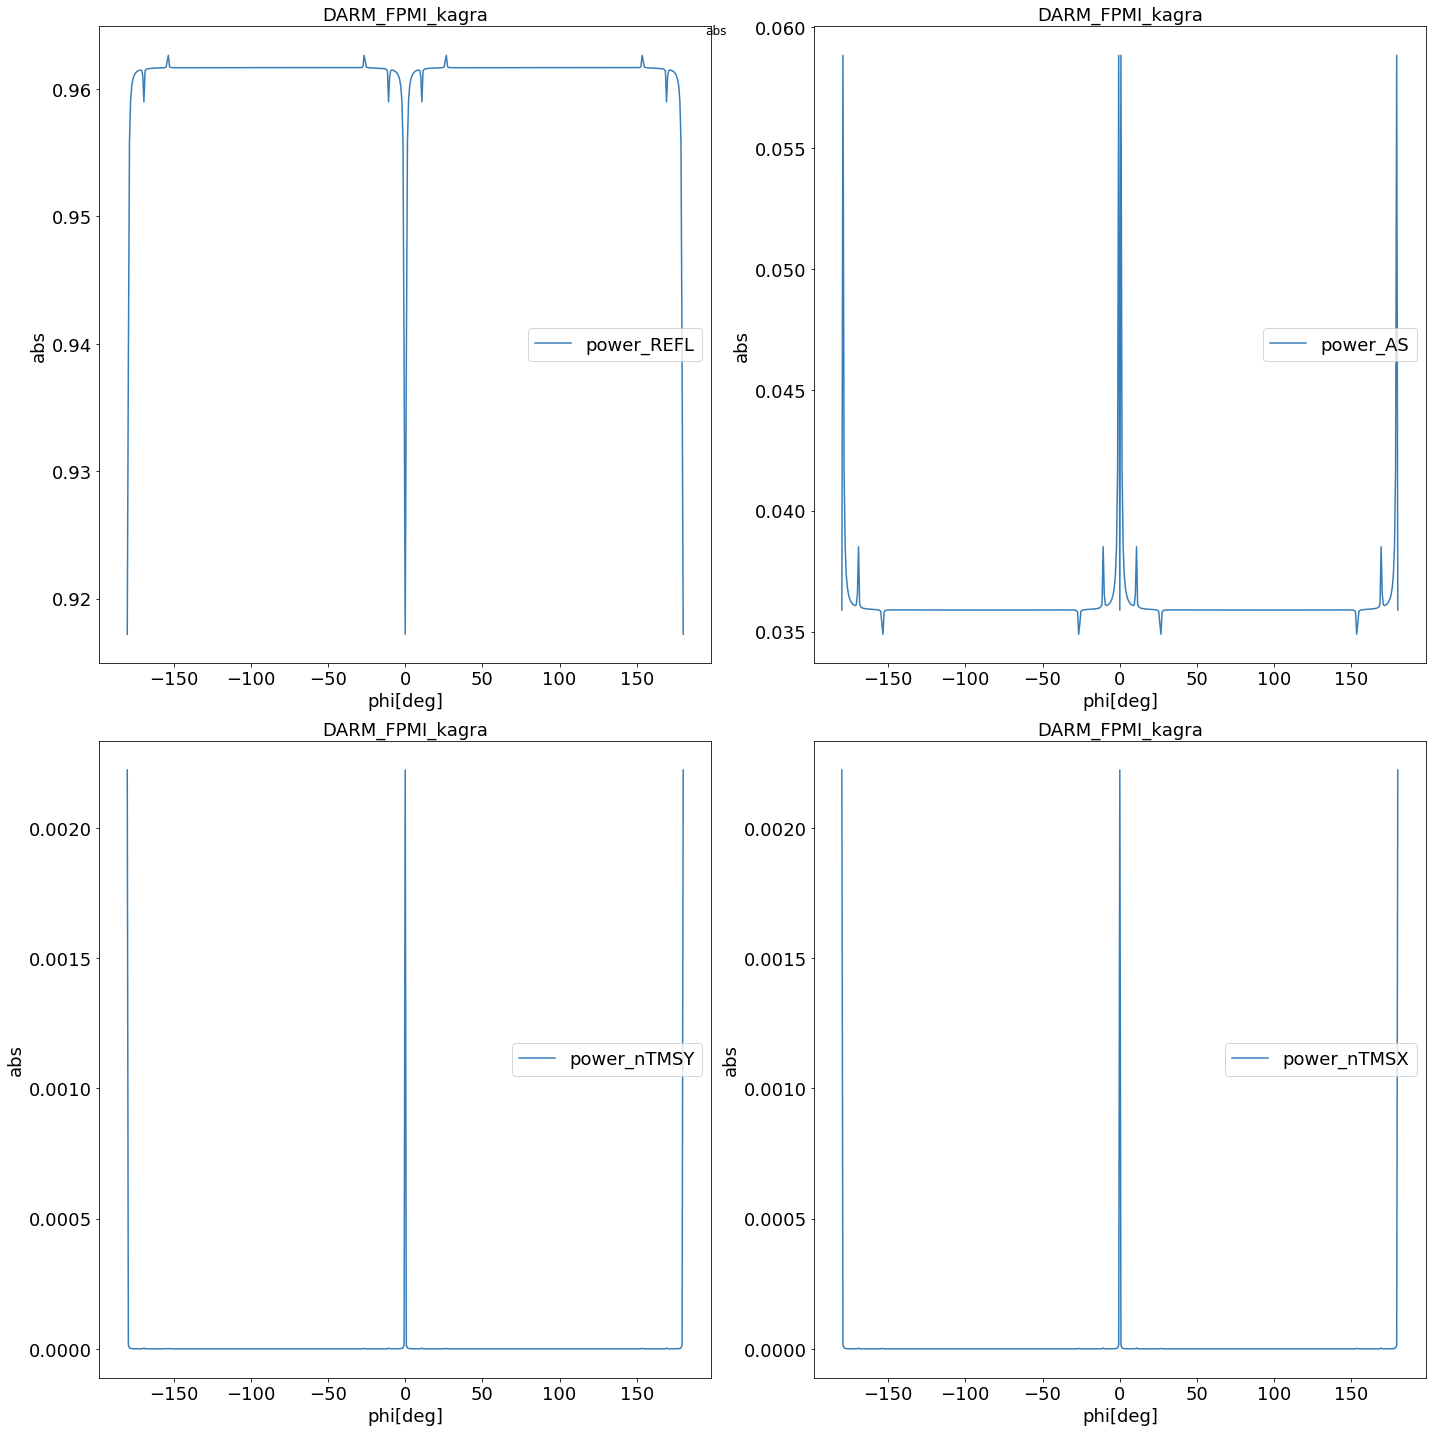

transferfunction_demod_2
k_inf_f_n1
k_inf_f_n4
k_inf_f_nTMSY
k_inf_f_nTMSX
k_inf_f_n2
k_inf_f_n3
k_inf_f_ny1
k_inf_f_nx1
k_inf_f_ny2
k_inf_f_nx2
k_inf_f_ny3
k_inf_f_nx3
k_inf_c_n1
k_inf_c_n4
k_inf_c_nTMSY
k_inf_c_nTMSX
k_inf_c_n2
k_inf_c_n3
k_inf_c_ny1
k_inf_c_nx1
k_inf_c_ny2
k_inf_c_nx2
k_inf_c_ny3
k_inf_c_nx3
['k_inf_f_n1', 'k_inf_f_n4', 'k_inf_f_nTMSY', 'k_inf_f_nTMSX', 'k_inf_f_n2', 'k_inf_f_n3', 'k_inf_f_ny1', 'k_inf_f_nx1', 'k_inf_f_ny2', 'k_inf_f_nx2', 'k_inf_f_ny3', 'k_inf_f_nx3']
['k_inf_f_n1', 'k_inf_f_n4', 'k_inf_f_nTMSY', 'k_inf_f_nTMSX']

    
### FPMI

const f1_SB 16.881M
const f2_SB 45.0159M

# Input optics
l i1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s 

100% | ETA:  0:00:00 | Calculating                                             /Users/yuzurihara/anaconda3/envs/mifsim37/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


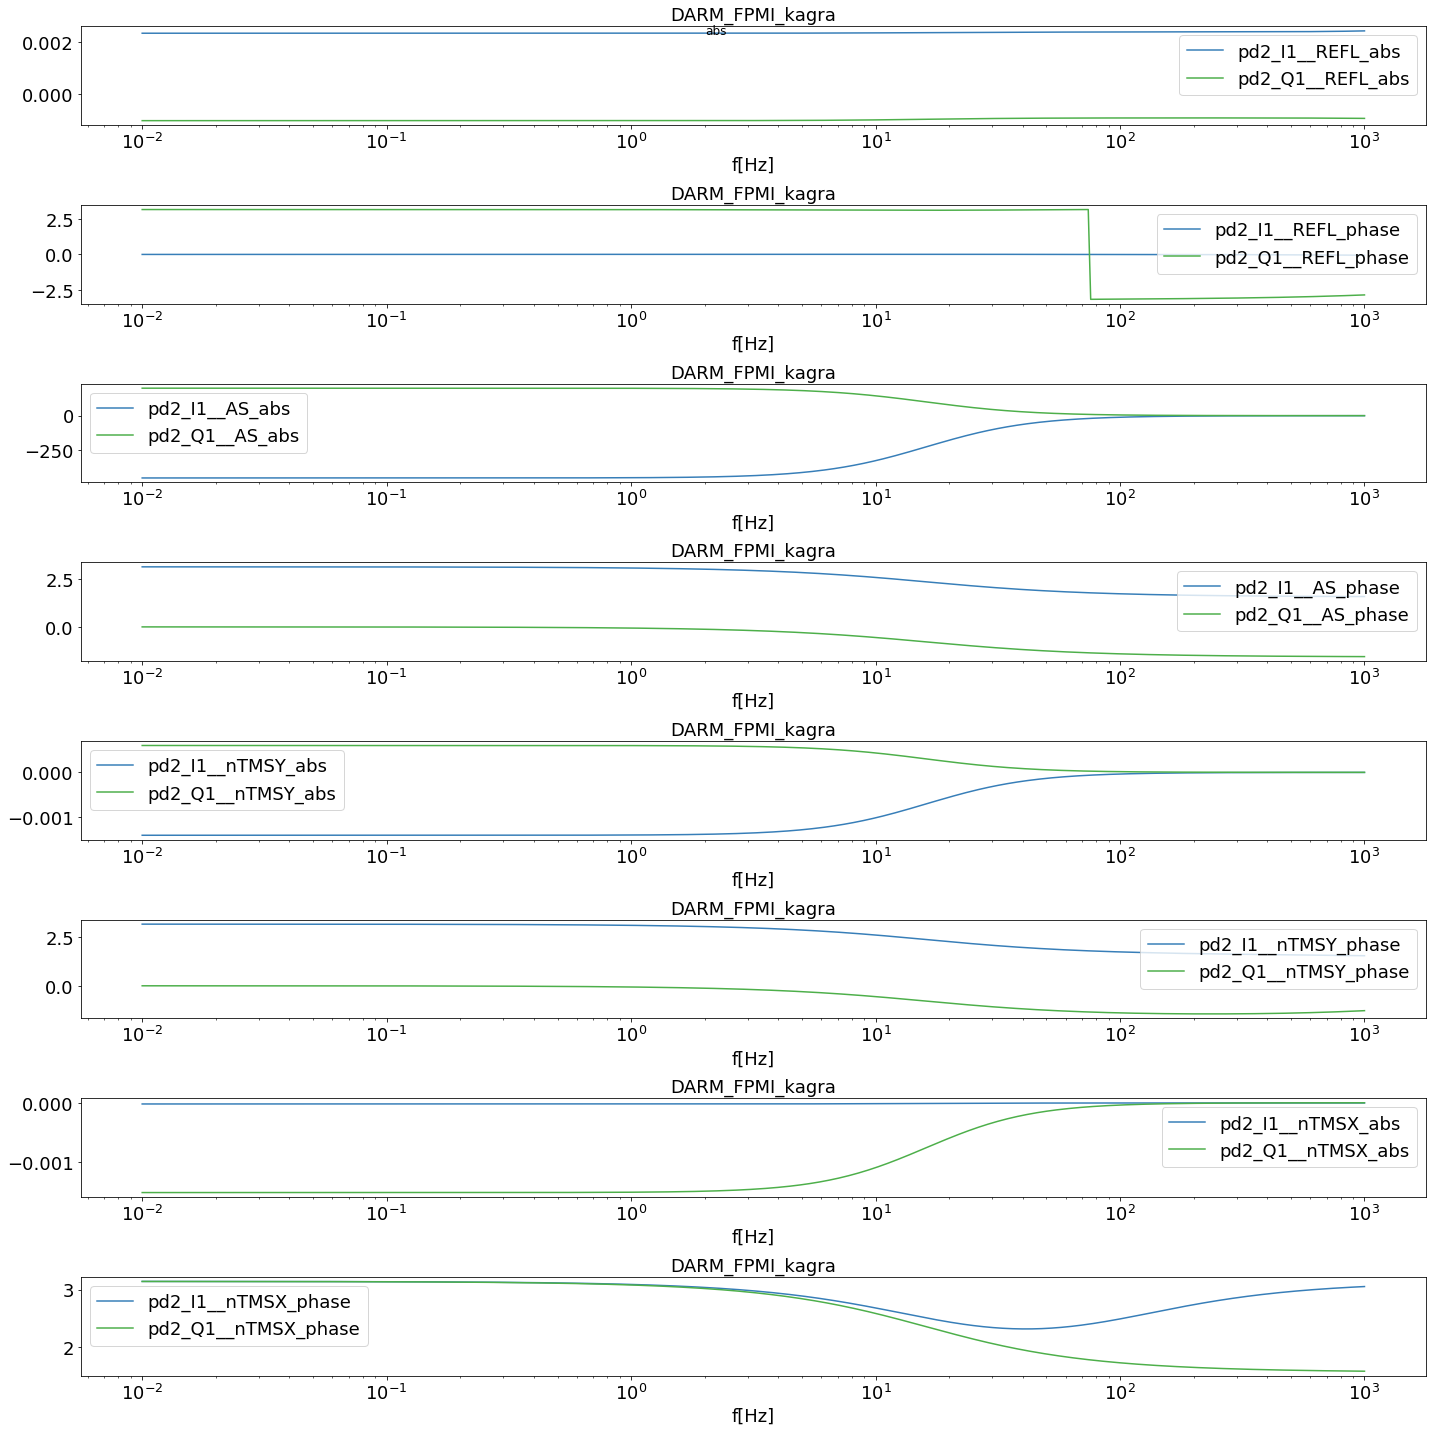

transferfunction_power
k_inf_f_n1
k_inf_f_n4
k_inf_f_nTMSY
k_inf_f_nTMSX
k_inf_f_n2
k_inf_f_n3
k_inf_f_ny1
k_inf_f_nx1
k_inf_f_ny2
k_inf_f_nx2
k_inf_f_ny3
k_inf_f_nx3
k_inf_c_n1
k_inf_c_n4
k_inf_c_nTMSY
k_inf_c_nTMSX
k_inf_c_n2
k_inf_c_n3
k_inf_c_ny1
k_inf_c_nx1
k_inf_c_ny2
k_inf_c_nx2
k_inf_c_ny3
k_inf_c_nx3
['k_inf_f_n1', 'k_inf_f_n4', 'k_inf_f_nTMSY', 'k_inf_f_nTMSX', 'k_inf_f_n2', 'k_inf_f_n3', 'k_inf_f_ny1', 'k_inf_f_nx1', 'k_inf_f_ny2', 'k_inf_f_nx2', 'k_inf_f_ny3', 'k_inf_f_nx3']
['k_inf_f_n1', 'k_inf_f_n4', 'k_inf_f_nTMSY', 'k_inf_f_nTMSX', 'k_inf_f_nx1']

    
### FPMI

const f1_SB 16.881M
const f2_SB 45.0159M

# Input optics
l i1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 

100% | ETA:  0:00:00 | Calculating                                             

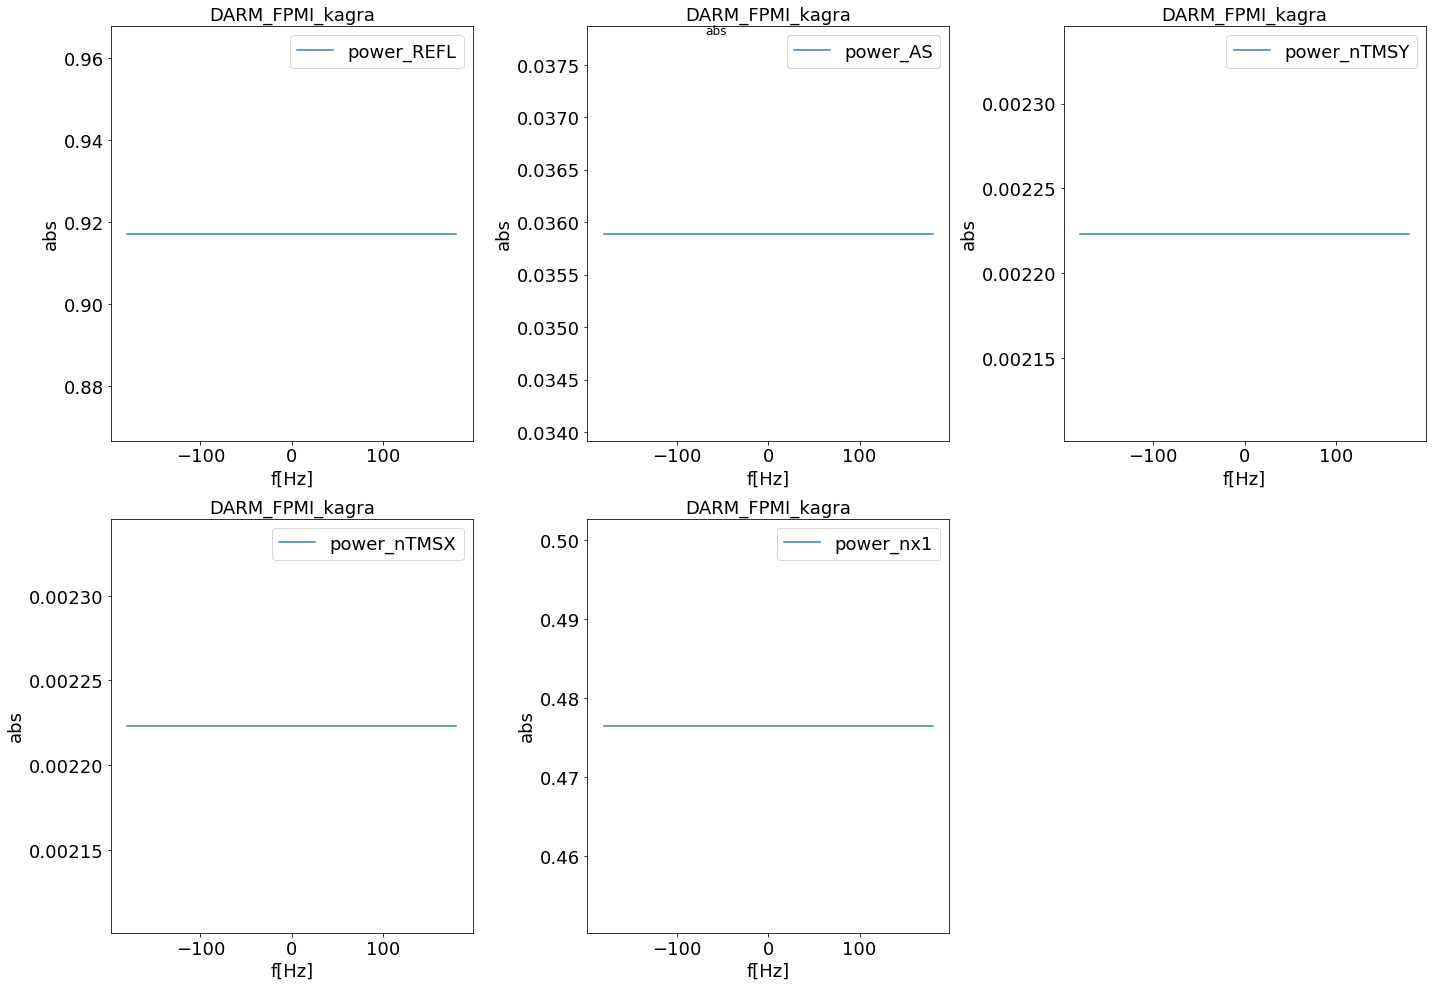

In [ ]:
##################################    
#section setting pd0/pd1/pd2
##################################
inf_f_section_pd0 = [

            ]
inf_f_section_pd1 = [
            [sg.Text('Which phase to plot?')],
            [sg.Checkbox('I1 and Q1 overplot)', size=(20, 1), key='k_inf_f_pd1_plot_I_Q_overplot_f1'),#(yuzu) I1 and Q1 overplotの後の括弧が不要または不足
            sg.Checkbox('I2 and Q2 overplot)', size=(20, 1), key='k_inf_f_pd1_plot_I_Q_overplot_f2')], #(yuzu) I2 and Q2 overplot)の括弧が不要または不足
            [sg.Checkbox('I1(in_phase f1)', size=(20, 1), key='k_inf_f_pd1_I1'),
            sg.Checkbox('Q1(quadrature_phase f1)', size=(20, 1), key='k_inf_f_pd1_Q1'),#(yuzu) 最後の2)の括弧が不要または不足
            sg.Checkbox('I2(in_phase f2)', size=(20, 1), key='k_inf_f_pd1_I2'),
            sg.Checkbox('Q2(quadrature_phase f2)', size=(20, 1), key='k_inf_f_pd1_Q2')],#(yuzu) 自分の環境ではsizeが足りていないので右が切れている、文章を短くする
            [sg.Text('Demodulation_frequency'),sg.Input(key='k_inf_f_pd1_demodfreq', default_text='0', enable_events=True)],
            [sg.Text('Demodulation_phase'),sg.Input(key='k_inf_f_pd1_demod_phase', default_text='0', enable_events=True)]
]
inf_f_section_pd2 = [
            [sg.Text('Which phase to plot?')],
            [sg.Checkbox('I1 and Q1 overplot)', size=(20, 1), default=True, key='k_inf_f_pd2_plot_I_Q_overplot_f1'),
            sg.Checkbox('I2 and Q2 overplot)', size=(20, 1), key='k_inf_f_pd2_plot_I_Q_overplot_f2')],
            [sg.Checkbox('I1(in_phase f1)', size=(20, 1), key='k_inf_f_pd2_I1'),
            sg.Checkbox('Q1(quadrature_phase f1)', size=(25, 1), key='k_inf_f_pd2_Q1'),
            sg.Checkbox('I2(in_phase f2)', size=(20, 1), key='k_inf_f_pd2_I2'),
            sg.Checkbox('Q2(quadrature_phase f2)', size=(25, 1), key='k_inf_f_pd2_Q2'),
            ],
            [sg.Text('mixer1 demodulation freq (0, 100, max)'), sg.Input(key='k_inf_f_pd2_mixer1_demodfreq', default_text='0', enable_events=True)],
            [sg.Text('Demodulation_phase'),sg.Input(key='k_inf_f_pd2_demod_phase', default_text='0', enable_events=True)]
]
inf_f_pd2_section_power = [

            ]
inf_f_sweep_section_how_simulate = [
            [sg.Radio('Power(pd0)', 'RADIO1', default=True, size=(20,1), key='k_inf_f_isscan', enable_events=True),# "%s_%s"
             sg.Radio('Demod_once(pd1)','RADIO1', default=False, size=(20,1), key='k_inf_f_isdemod_1', enable_events=True)],
            ### pd0_setting_section
            [collapse(inf_f_section_pd0, 'k_inf_f_pd0_setting_section')],
            ### pd1_settnig_section
            [collapse(inf_f_section_pd1, 'k_inf_f_pd1_setting_section')]
            ]
inf_f_transferfunction_section_how_simulate = [
    [sg.Radio('Power(pd0)', 'pd2_RADIO', default=True, size=(20,1), key='k_inf_f_istransferfunction_power', enable_events=True),
    sg.Radio('Demod(pd2)','pd2_RADIO', default=False, size=(20,1), key='k_inf_f_istransferfunction_demod_2', enable_events=True)],
    #
    #sg.Radio('altanative way','pd2_RADIO', default=False, size=(20,1), key='k_inf_f_istransferfunction_alt', enable_events=True)
    ### pd2_setting_section
    [collapse(inf_f_pd2_section_power, 'k_inf_f_pd2_section_power')],
    ### pd2_setting_section
    [collapse(inf_f_section_pd2, 'k_inf_f_pd2_setting_section')]
]
###
# inf_f_ picture expand
###

##################################    
#TAB select FPMI/PRFPMI/DRFPMI
##################################
inf_p_layout =  [
                ]
inf_d_layout =  [
                ]
inf_m_layout =  [
                ]
#inf_f_tab
inf_f_layout = [
                [sg.Image('./Fabry_Perot_MI_eom_drawing.png', key='k_inf_f_imageContainer', size=(400,300))],#size=(800,600)
                #[sg.Image('/Users/koyamanaoki/work/MIF/local/FPMI_pic2.png', key='k_inf_f_imageContainer', size=(400,300))],#size=(800,600)
                #[sg.Button('expand', button_color=('white', 'black'), key='k_inf_f_imageContainer_expand')],
                #[sg.Button('expand_s', button_color=('white', 'black'), key='k_inf_f_imageContainer_expand_s')],
                ### RADIO BOX pd0/pd1/pd2
                [sg.Text('1. Select Sweep or Transfer function ')],
                [sg.Text('A new option list is displayed when you select the Sweep or Transfer function.')],# あとで消す
                [sg.Radio('Sweep', 'HOW_SIMULATE01', default=True, size=(10,1), key='k_inf_f_issweep', enable_events=True),
                 sg.Radio('Transfer function(pd2)', 'HOW_SIMULATE01', default=False, size=(25,1), key='k_inf_f_istransfunc', enable_events=True)],
                ### RADIO BOX pd0/pd1/pd2
                [collapse(inf_f_sweep_section_how_simulate, 'k_inf_f_sweep_section_how_simulate')],
                ### RADIO BOX pd0/pd1/pd2
                [collapse(inf_f_transferfunction_section_how_simulate, 'k_inf_f_transferfunction_section_how_simulate')],
                [sg.Text('2. Select which Dof to move')],
                [sg.Text('　　DoF'),sg.Combo(('DARM', 'CARM', 'BS'),default_value='DARM', size=(20, 1),key='k_inf_f_dof')], #RADIOBOXに変える
                ## PDs checkbox
                [sg.Text('3. Select port (see the top figure)')],#図と関連あるとかく
                [sg.Text('check PDs')],#あとで消す
                [sg.Checkbox('REFL', size=(10, 1), default=True, key='k_inf_f_n1'),sg.Checkbox('AS', size=(5, 1),default=True, key='k_inf_f_n4'),
                sg.Checkbox('nTMSY', size=(10, 1), default=True,key='k_inf_f_nTMSY'),sg.Checkbox('nTMSX', size=(10, 1), default=True, key='k_inf_f_nTMSX')],
                [sg.Checkbox('n2', size=(5, 1), key='k_inf_f_n2'),sg.Checkbox('n3', size=(5, 1), key='k_inf_f_n3'),
                sg.Checkbox('ny1', size=(7, 1), key='k_inf_f_ny1'),sg.Checkbox('nx1', size=(7, 1), key='k_inf_f_nx1'),
                sg.Checkbox('ny2', size=(7, 1), key='k_inf_f_ny2'),sg.Checkbox('nx2', size=(7, 1), key='k_inf_f_nx2'),
                sg.Checkbox('ny3', size=(7, 1), key='k_inf_f_ny3'),sg.Checkbox('nx3', size=(7, 1), key='k_inf_f_nx3'),
                ],
                #
                #
                [sg.Button('Plot', button_color=('white', 'black'), key='k_inf_f_event')],
                ]
### EXTRA OPTION TAB
extra_option_tab =  [
                #other settings
                [sg.Text('laser_power [W]'), sg.Input(key='k_inf_c_laser_power', default_text='1')],
                ### xaxis range
                [sg.Radio('xaxis lin', 'x_plotscale', default=True, size=(10,1), key='k_inf_c_xaxis_lin', enable_events=True),
                sg.Radio('xaxis log','x_plotscale', default=False, size=(10,1), key='k_inf_c_xaxis_log', enable_events=True)],
                ### yaxis range
                [sg.Radio('yaxis lin', 'y_plotscale', default=True, size=(10,1), key='k_inf_c_yaxis_lin', enable_events=True),
                sg.Radio('yaxis log','y_plotscale', default=False, size=(10,1), key='k_inf_c_yaxis_log', enable_events=True)],
                [sg.Text('sampling num'), sg.Input(key='k_inf_f_samplingnum', default_text='500', enable_events=True)],
                [sg.Text('Which data you output?')],
                [sg.Checkbox('kat file', size=(15, 1), key='k_inf_c_output_kat'), sg.Checkbox('plotdata', size=(15, 1), key='k_inf_c_output_plotdata')]
                ]
layout = [
            [sg.TabGroup([[sg.Tab('FPMI', inf_f_layout), sg.Tab('PRFPMI', inf_p_layout), sg.Tab('DRFPMI', inf_d_layout), sg.Tab('MI', inf_m_layout), sg.Tab('OPTION', extra_option_tab)]])],
            [sg.Text('xaxis range', size=(20,1), key='k_inf_c_xaxis_range_text')],
            [sg.Input(key='k_inf_c_xaxis_range_beg', default_text='-180', enable_events=True), sg.Text('to'), sg.Input(key='k_inf_c_xaxis_range_end', default_text='180', enable_events=True)]
            ] 
# (yuzu) k_inf_c_xaxis_range_begと k_inf_c_xaxis_range_endはすべてのタブについて共通？
# もしそうなら、keyの名前はfpmiと関連付けないほうが良いと思う

window = sg.Window('My window with tabs', layout, default_element_size=(12,1), finalize=True)    

type_of_pd_signal =''
#fname_output='' あとで消す
#fname_kat=''
check = False
#default
type_of_pd_signal = 'sweep_power'
#
#
#
while True:    
    if(check==False):
        window['k_inf_f_sweep_section_how_simulate'].update(visible=True)
        window['k_inf_f_transferfunction_section_how_simulate'].update(visible=False)
        window['k_inf_f_pd0_setting_section'].update(visible=True)
        window['k_inf_f_pd1_setting_section'].update(visible=False)
        window['k_inf_f_pd2_section_power'].update(visible=False)
        window['k_inf_f_pd2_setting_section'].update(visible=False)
        check = True
    event, values = window.read()

    #print(event,values)
    if event == sg.WIN_CLOSED:
        break
    if event == 'k_inf_f_Exit':
        break        
    if event == 'k_inf_f_imageContainer_expand':
        window['k_inf_f_imageContainer'].update('/Users/koyamanaoki/work/MIF/local/FPMI_pic.png')
    if event == 'k_inf_f_imageContainer_expand_s':
        #window['k_inf_f_imageContainer'].update(data=convert_to_bytes('/Users/koyamanaoki/work/MIF/local/FPMI_pic.png', resize=(800, 600)))
        window['k_inf_f_imageContainer'].update(size=(760, 500))
    if event == 'k_inf_c_xaxis_range_beg' and values['k_inf_c_xaxis_range_beg'] and values['k_inf_c_xaxis_range_beg'][-1] not in ('0123456789.-'):
        window['k_inf_c_xaxis_range_beg'].update(values['k_inf_c_xaxis_range_beg'][:-1])
    if event == 'k_inf_c_xaxis_range_end' and values['k_inf_c_xaxis_range_end'] and values['k_inf_c_xaxis_range_end'][-1] not in ('0123456789.-'):
        window['k_inf_c_xaxis_range_end'].update(values['k_inf_c_xaxis_range_end'][:-1])
    ### update xaxis default value
    if event == 'k_inf_c_xaxis_lin':
        default_xaxis_beg = '-180'
        default_xaxis_end = '180'
        window['k_inf_c_xaxis_range_beg'].update(default_xaxis_beg)
        window['k_inf_c_xaxis_range_end'].update(default_xaxis_end)
    if event == 'k_inf_c_xaxis_log':
        default_xaxis_beg = '0.01'
        default_xaxis_end = '1000'
        window['k_inf_c_xaxis_range_beg'].update(default_xaxis_beg)
        window['k_inf_c_xaxis_range_end'].update(default_xaxis_end)
    ### visible/invisible advanced setting
    #
    # この辺を関数にできそう。Trueにして欲しいウィンドウの名前を渡してそれ以外全部Falseにするとか
    # window, keylist, Trueにするkeylist 引数
    # 一番長い
    if event == 'k_inf_f_issweep':
        window['k_inf_f_sweep_section_how_simulate'].update(visible=True)
        window['k_inf_f_transferfunction_section_how_simulate'].update(visible=False)
        window['k_inf_f_pd0_setting_section'].update(visible=True)
        window['k_inf_f_pd1_setting_section'].update(visible=False)
        window['k_inf_f_pd2_section_power'].update(visible=False)
        window['k_inf_f_pd2_setting_section'].update(visible=False)
        default_xaxis_beg = '-180'
        default_xaxis_end = '180'
        window['k_inf_c_xaxis_range_beg'].update(default_xaxis_beg)
        window['k_inf_c_xaxis_range_end'].update(default_xaxis_end)
        #default value
        type_of_pd_signal = 'sweep_power'
    if event == 'k_inf_f_istransfunc':
        window['k_inf_f_sweep_section_how_simulate'].update(visible=False)
        window['k_inf_f_transferfunction_section_how_simulate'].update(visible=True)
        window['k_inf_f_pd0_setting_section'].update(visible=False)
        window['k_inf_f_pd1_setting_section'].update(visible=False)
        window['k_inf_f_pd2_section_power'].update(visible=True)
        window['k_inf_f_pd2_setting_section'].update(visible=False)
        default_xaxis_beg = '-180'
        default_xaxis_end = '180'
        window['k_inf_c_xaxis_range_beg'].update(default_xaxis_beg)
        window['k_inf_c_xaxis_range_end'].update(default_xaxis_end)
        #default value
        type_of_pd_signal = 'transferfunction_power'
    if event == 'k_inf_isscan':
        window['k_inf_f_pd0_setting_section'].update(visible=True)
        window['k_inf_f_pd1_setting_section'].update(visible=False)
        window['k_inf_f_pd2_section_power'].update(visible=False)
        window['k_inf_f_pd2_setting_section'].update(visible=False)
        type_of_pd_signal = 'sweep_power'
        ## default xrange value ##
        window['k_inf_c_xaxis_range_text'].update('xaxis sweep[deg] range')
        values['k_inf_c_xaxis_lin'] = True
        values['k_inf_c_xaxis_log'] = False
        window['k_inf_c_xaxis_lin'].update(True)
        window['k_inf_c_xaxis_log'].update(False)
        default_xaxis_beg = '-180'
        default_xaxis_end = '180'
        window['k_inf_c_xaxis_range_beg'].update(default_xaxis_beg)
        window['k_inf_c_xaxis_range_end'].update(default_xaxis_end)
    if event == 'k_inf_f_isdemod_1':
        window['k_inf_f_pd0_setting_section'].update(visible=False)
        window['k_inf_f_pd1_setting_section'].update(visible=True)
        window['k_inf_f_pd2_section_power'].update(visible=False)
        window['k_inf_f_pd2_setting_section'].update(visible=False)
        type_of_pd_signal = 'sweep_demod_1'
        ## default xrange value ##
        window['k_inf_c_xaxis_range_text'].update('xaxis sweep[deg] range')
        values['k_inf_c_xaxis_lin'] = True
        values['k_inf_c_xaxis_log'] = False
        window['k_inf_c_xaxis_lin'].update(True)
        window['k_inf_c_xaxis_log'].update(False)
        default_xaxis_beg = '-180'
        default_xaxis_end = '180'
        window['k_inf_c_xaxis_range_beg'].update(default_xaxis_beg)
        window['k_inf_c_xaxis_range_end'].update(default_xaxis_end)
    if event == 'k_inf_f_istransferfunction_power':
        window['k_inf_f_pd0_setting_section'].update(visible=False)
        window['k_inf_f_pd1_setting_section'].update(visible=False)
        window['k_inf_f_pd2_section_power'].update(visible=True)
        window['k_inf_f_pd2_setting_section'].update(visible=False)
        type_of_pd_signal = 'transferfunction_power'
        ## default xrange value ##
        window['k_inf_c_xaxis_range_text'].update('xaxis sweep[deg] range')
        values['k_inf_c_xaxis_lin'] = True
        values['k_inf_c_xaxis_log'] = False
        window['k_inf_c_xaxis_lin'].update(True)
        window['k_inf_c_xaxis_log'].update(False)
        default_xaxis_beg = '-180'
        default_xaxis_end = '180'
        window['k_inf_c_xaxis_range_beg'].update(default_xaxis_beg)
        window['k_inf_c_xaxis_range_end'].update(default_xaxis_end)
    if event == 'k_inf_f_istransferfunction_demod_2':
        window['k_inf_f_pd0_setting_section'].update(visible=False)
        window['k_inf_f_pd1_setting_section'].update(visible=False)
        window['k_inf_f_pd2_section_power'].update(visible=False)
        window['k_inf_f_pd2_setting_section'].update(visible=True)
        type_of_pd_signal = 'transferfunction_demod_2'
        ## default xrange value ##
        window['k_inf_c_xaxis_range_text'].update('xaxis f[Hz] range')
        values['k_inf_c_xaxis_lin'] = False
        values['k_inf_c_xaxis_log'] = True
        window['k_inf_c_xaxis_lin'].update(False)
        window['k_inf_c_xaxis_log'].update(True)
        default_xaxis_beg = '0.01'
        default_xaxis_end = '1000'
        window['k_inf_c_xaxis_range_beg'].update(default_xaxis_beg)
        window['k_inf_c_xaxis_range_end'].update(default_xaxis_end)
        '''
        if event == 'k_inf_f_istransferfunction_alt':
            window['k_inf_f_pd0_setting_section'].update(visible=False)
            window['k_inf_f_pd1_setting_section'].update(visible=False)
            window['k_inf_f_pd2_section_power'].update(visible=False)
            window['k_inf_f_pd2_setting_section'].update(visible=True)
            type_of_pd_signal = 'transferfunction_alt'
            ## default xrange value ##
            window['k_inf_c_xaxis_range_text'].update('xaxis f[Hz] range')
            values['k_inf_c_xaxis_lin'] = False
            values['k_inf_c_xaxis_log'] = True
            window['k_inf_c_xaxis_lin'].update(False)
            window['k_inf_c_xaxis_log'].update(True)
            default_xaxis_beg = '0.01'
            default_xaxis_end = '1000'
            window['k_inf_c_xaxis_range_beg'].update(default_xaxis_beg)
            window['k_inf_c_xaxis_range_end'].update(default_xaxis_end)
        '''        

# (yuzu) 以下のような感じで、event(ユーザーがどのプロットボタンをクリックしたかによって分岐)とタブが関連付けられる
# keyの名前は置換しやすいように、k+干渉計構成という名前にしたが、他に良いアイデアがあれば別のでもOK
# ただし、人が見てわかるような名前にしたほうが良いのと、できるだけ短いほうが良い
#
#    if event == 'k_inf_f_event':           # FPMI    
#        interferomere = 'kfpmi'
#    if event == 'k_inf_....':           # PRFPMI  
#        interferomere = 'kprfpmi'
#    if event == 'k_inf_....':           # DRFPMI  
#        interferomere = 'kdrfpmi'
        
    if event == 'k_inf_f_event':           # FPMI
        interferometer_configuration = 'FPMI'
        print(type_of_pd_signal)
        ###############################
        ### get variables from GUI ###
        ###############################

#
# (yuzu) 試してみたら、dic_inf_f_ispdsという辞書型に実際にないkeyを入れるとエラーが出た
# なので、今の実装の仕方だとこの辞書型は干渉計構成の数だけ用意しないといけない
# が、それをやるとその後のプロットの部分が煩雑になる
# 
# 1つの解決方法としては、まずすべてのpdのkeyを書いたリストを用意する
# 下のプロットの中で、以下のようにpdをリストアップしてその中でTrueなリストを作っているが、それをすべてここで一括で事前にやっておくと楽になる
# 理想を言うと、これよりも下ではvalueというリストは一切参照しない
#
#
#                inf_f_list_demon_phase = ['k_inf_f_pd2_I1', 'k_inf_f_pd2_Q1', 
#                                            'k_inf_f_pd2_plot_I_Q_overplot_f1', 
#                                            'k_inf_f_pd2_I2', 'k_inf_f_pd2_Q2', 
#                                            'k_inf_f_pd2_plot_I_Q_overplot_f2'
#                                            ]
#                inf_f_list_demon_phase_name = ['pd2_I1', 'pd2_Q1', 
#                                            'pd2_plot_I_Q_overplot_f1', 
#                                            'pd2_I2', 'pd2_Q2', 
#                                            'pd2_plot_I_Q_overplot_f2']
#                inf_f_list_demon_phase_True = [k for k in inf_f_list_demon_phase if values[k] == True]


        pd_list=[] # 空のリストを作っておく
        pd_tails=['n1', 'n4', 'nTMSY', 'nTMSX', 'n2', 'n3', 'ny1', 'nx1', 'ny2', 'nx2', 'ny3', 'nx3'] # 他にもあるならこれの後ろに追加する
        #interferometers=['kfpmi', 'kprfpmi', 'kdrfpmi'] #これはイベントの名前やpdのkeyの頭の名前と一致させる
        interferometers=['k_inf_f', 'k_inf_c'] # 'k_inf_c'はテストのために入れただけ
        # 
        for interferometer in interferometers:
            for pd in pd_tails:
                pd = '%s_%s' % (interferometer, pd)
                print(pd)
                if pd in values:
                    pd_list.append(pd) # ここで干渉計の名前とpdの名前を組み合わせて、valuesに入っているkeyの名前のリストを作る
                    # k_inf_c_n1というkeyはvalueにはないので、ここで弾かれる
                    #これですべての干渉計構成のpd名のうち、今有効なものkey名をリストアップできる

        print(pd_list)

        pds = [pd for pd in pd_list if values[pd] == True] # valuesに入っているkeyでTrueなものだけ
        print(pds)
        # dic_inf_f_ispdsの代わりにpdsというリストを用いれば良い

    #
    # (2020/09/02)この下がタブ全部で共通にできると短くなる
    #        
        
    ### PD location ###
        dic_inf_f_ispds = {
            ### PDs
            #'REFL':values['%s_REFL' % interferometer],
            'REFL':values['k_inf_f_n1'],#bool #REFL
            'AS':values['k_inf_f_n4'],#bool #AS
            'nTMSY':values['k_inf_f_nTMSY'],#bool
            'nTMSX':values['k_inf_f_nTMSX'],#bool
            'n2':values['k_inf_f_n2'],#bool
            'n3':values['k_inf_f_n3'],#bool
            'ny1':values['k_inf_f_ny1'],#bool
            'nx1':values['k_inf_f_nx1'],#bool
            'ny2':values['k_inf_f_ny2'],#bool
            'nx2':values['k_inf_f_nx2'],#bool
            'ny3':values['k_inf_f_ny3'],#bool
            'nx3':values['k_inf_f_nx3'],#bool
        }
        #########
        #
        # plot variables
        # 
        xaxis_range_beg = values['k_inf_c_xaxis_range_beg']
        xaxis_range_end = values['k_inf_c_xaxis_range_end']
        #yaxis_range_beg = values['yaxis_range_beg']
        #yaxis_range_end = values['yaxis_range_end']

        if(values['k_inf_c_xaxis_log'] == True):
            x_plotscale = 'log'
        else:
            x_plotscale = 'linear'
        if(values['k_inf_c_yaxis_log'] == True):
            y_plotscale = 'log'
        else:
            y_plotscale = 'linear'   
        #########
        dic_inf_f_advanced_setting = {
            ### DoF
            'dof':values['k_inf_f_dof'],#str
            ### pd0/pd1/pd2?
            
            'type_of_pd_signal':type_of_pd_signal,#str
            ### advanced setting
            'laser_power':values['k_inf_c_laser_power'],#str
            #
            # plot variables
            # 
            'x_plotscale':x_plotscale,#str
            'xaxis_range_beg':values['k_inf_c_xaxis_range_beg'],#str
            'xaxis_range_end':values['k_inf_c_xaxis_range_end'],#str
            'y_plotscale':y_plotscale,#str
            #'yaxis_range_beg':values['k_inf_c_yaxis_range_beg'],#str
            #'yaxis_range_end':values['k_inf_c_yaxis_range_end'],#str
            'pd1_demod_phase':values['k_inf_f_pd1_demod_phase'],#str
            'pd1_demodfreq':values['k_inf_f_pd1_demodfreq'],#str
            'pd2_demod_phase':values['k_inf_f_pd2_demod_phase'],#str
            'pd2_mixer1_demodfreq':values['k_inf_f_pd2_mixer1_demodfreq'],#str
            'samplingnum':values['k_inf_f_samplingnum'],#str
            }
        
        kat = finesse.kat()
        code = generate_kat_FPMI(dic_inf_f_ispds, dic_inf_f_advanced_setting)
        kat.parse(code)
        out = kat.run()
        plot_title = '%s_%s_kagra' % (values['k_inf_f_dof'], interferometer_configuration)

        #
        # 下のやつ3つ共通にできるか考える
        #

        ### scan
        if(type_of_pd_signal == 'sweep_power' or type_of_pd_signal == 'transferfunction_power'):
            fig1 = plt.figure(figsize=(20,20))
            #print(x_plotscale)
            #print(y_plotscale)
            #plt.xscale(x_plotscale)
            #plt.yscale(y_plotscale)
            # ここでも結果表示できるか調べる
            # (yuzu) これは試したけど、無理でした・・・
            fig1.suptitle('abs')
            plotnum = 0
            for key in dic_inf_f_ispds.keys():
                if dic_inf_f_ispds[key] == True:
                    plotnum += 1 #plotnum
            vh_plotnum = math.ceil(math.sqrt(plotnum))
            if(plotnum > 0):
                #for i in range(plotnum):
                i = 0
                for key in dic_inf_f_ispds.keys():
                    if dic_inf_f_ispds[key]==True:
                        plt.subplot(vh_plotnum,vh_plotnum,i+1) #Axes
                        plt.plot(out.x, out['pd0_%s' % key], label='power_%s' % key, color = '#377eb8')
                        plt.xscale(x_plotscale)
                        plt.yscale(y_plotscale)
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.ylabel('abs', fontsize=18) # (yuzu) ここにもfontsizeを付けないと小さい
                        ## change title to configuration name
                        plt.title('%s' % plot_title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        # 凡例の表示
                        plt.legend(fontsize=18) # (yuzu) すべての凡例の大きさをxlabelとかと同じにしたほうが見栄えが良いしみやすい
                        i += 1
            plt.tight_layout()
        ### demod once (pd1)
        if(type_of_pd_signal=='sweep_demod_1'):
            # 
            fig1 = plt.figure(figsize=(20,20))
            #fig1.suptitle('absolute value')
            plotnum = 0
            for key in dic_inf_f_ispds.keys():
                if dic_inf_f_ispds[key] == True:
                    plotnum += 1 #plotnum
            if(plotnum > 0):
                i = 0
                inf_f_list_demon_phase = ['k_inf_f_pd1_I1', 'k_inf_f_pd1_Q1', 
                                            'k_inf_f_pd1_plot_I_Q_overplot_f1', 
                                            'k_inf_f_pd1_I2', 'k_inf_f_pd1_Q2', 
                                            'k_inf_f_pd1_plot_I_Q_overplot_f2']
                inf_f_list_demon_phase_name = ['pd1_I1', 'pd1_Q1', 
                                                'pd1_plot_I_Q_overplot_f1', 
                                                'pd1_I2', 'pd1_Q2', 
                                                'pd1_plot_I_Q_overplot_f2']
                inf_f_list_demon_phase_True = [k for k in inf_f_list_demon_phase if values[k] == True]
                j = len(inf_f_list_demon_phase_True)
                print('j'+str(j))
                if(j==0):
                    values['k_inf_f_pd1_I1'] = True
                    j = 1
                #plotの横の数
                h_plotnum = j
                #plotの縦の数
                v_plotnum = plotnum
                for key in dic_inf_f_ispds.keys():
                    if dic_inf_f_ispds[key] == True:
                        k = 1
                        for l in range(len(inf_f_list_demon_phase)):
                            if (values[inf_f_list_demon_phase[l]]==True):
                                # abs
                                plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                                if(inf_f_list_demon_phase[l]=='k_inf_f_pd1_plot_I_Q_overplot_f1'):
                                    plt.plot(out.x, out['pd1_I1_%s' % (key)], label='pd1_I1__%s_abs' % (key), color = '#377eb8')
                                    plt.plot(out.x, out['pd1_Q1_%s' % (key)], label='pd1_Q1__%s_abs' % (key), color = '#4daf4a')
                                elif(inf_f_list_demon_phase[l]=='k_inf_f_pd1_plot_I_Q_overplot_f2'):
                                    plt.plot(out.x, out['pd1_I2_%s' % (key)], label='pd1_I2__%s_abs' % (key), color = '#377eb8')
                                    plt.plot(out.x, out['pd1_Q2_%s' % (key)], label='pd1_Q2__%s_abs' % (key), color = '#4daf4a')
                                else:
                                    plt.plot(out.x, out['%s_%s' % (inf_f_list_demon_phase_name[l], key)], label='%s_%s_abs' % (inf_f_list_demon_phase_name[l], key), color = '#377eb8')
                                plt.xscale(x_plotscale)
                                plt.yscale(y_plotscale)
                                plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                                # (yuzu) ylabelを付けたほうが良い
                                plt.title('%s' % plot_title, fontsize=18)
                                plt.tick_params(labelsize=18)
                                # 凡例の表示
                                plt.legend(fontsize=18) # (yuzu) すべての凡例の大きさをxlabelとかと同じにしたほうが見栄えが良いしみやすい
                                k += 1
                        i += j
            plt.tight_layout()
        ## demod phase tuning
        '''
        if (type_of_pd_signal=='transferfunction_alt'):
            fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))
            for pp in np.linspace(0,180,7):
                PRCL_sweep.REFLI1.phase1 = pp
                PRCL_sweep.REFLQ1.phase1 = pp+90
                PRCL = PRCL_sweep.run()
                ax1.plot(PRCL.x, PRCL["REFLI1"],label=pp)
                ax2.plot(PRCL.x, PRCL["REFLQ1"],label=pp)
            plt.legend(loc=1)
        '''
        ### Transfer function(pd2)
        if(type_of_pd_signal=='transferfunction_demod_2'):
            fig1 = plt.figure(figsize=(20,20))
            fig1.suptitle('abs')
            plotnum = 0
            for key in dic_inf_f_ispds.keys():
                if dic_inf_f_ispds[key] == True:
                    plotnum += 1 #plotnum
            if(plotnum > 0):
                i = 0
                inf_f_list_demon_phase = ['k_inf_f_pd2_I1', 'k_inf_f_pd2_Q1', 
                                            'k_inf_f_pd2_plot_I_Q_overplot_f1', 
                                            'k_inf_f_pd2_I2', 'k_inf_f_pd2_Q2', 
                                            'k_inf_f_pd2_plot_I_Q_overplot_f2'
                                            ]
                inf_f_list_demon_phase_name = ['pd2_I1', 'pd2_Q1', 
                                            'pd2_plot_I_Q_overplot_f1', 
                                            'pd2_I2', 'pd2_Q2', 
                                            'pd2_plot_I_Q_overplot_f2']
                inf_f_list_demon_phase_True = [k for k in inf_f_list_demon_phase if values[k] == True]
                j = len(inf_f_list_demon_phase_True)
                print('j'+str(j))
                if(j==0):
                    values['k_inf_f_pd2_I1'] = True
                    j = 1
                #plotの横の数
                h_plotnum = j
                #plotの縦の数
                v_plotnum = 2*plotnum
                for key in dic_inf_f_ispds.keys():
                    if dic_inf_f_ispds[key] == True:
                        k = math.floor((i/h_plotnum))*2*h_plotnum + i%h_plotnum+1
                        for l in range(len(inf_f_list_demon_phase)):
                            if (values[inf_f_list_demon_phase[l]]==True):
                                # abs
                                plt.subplot(v_plotnum,h_plotnum,k) #Axes

                                if(inf_f_list_demon_phase[l]=='k_inf_f_pd2_plot_I_Q_overplot_f1'):
                                    plt.plot(out.x, out['pd2_I1_%s' % (key)], label='pd2_I1__%s_abs' % (key), color = '#377eb8')
                                    plt.plot(out.x, out['pd2_Q1_%s' % (key)], label='pd2_Q1__%s_abs' % (key), color = '#4daf4a')
                                elif(inf_f_list_demon_phase[l]=='k_inf_f_pd2_plot_I_Q_overplot_f2'):
                                    plt.plot(out.x, out['pd2_I2_%s' % (key)], label='pd2_I2__%s_abs' % (key), color = '#377eb8')
                                    plt.plot(out.x, out['pd2_Q2_%s' % (key)], label='pd2_Q2__%s_abs' % (key), color = '#4daf4a')
                                else:
                                    plt.plot(out.x, out['%s_%s' % (inf_f_list_demon_phase_name[l], key)], label='%s_%s_abs' % (inf_f_list_demon_phase_name[l], key), color = '#377eb8')
                                plt.xscale(x_plotscale) # (yuzu) これがないから、absだけlogになってなかった
                                plt.yscale(y_plotscale) # (yuzu) これがないから、absだけlogになってなかった
                                plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                                plt.title('%s' % plot_title, fontsize=18)
                                plt.tick_params(labelsize=18)
                                # 凡例の表示
                                plt.legend(fontsize=18) # (yuzu) すべての凡例の大きさをxlabelとかと同じにしたほうが見栄えが良いしみやすい

                                # phase
                                plt.subplot(v_plotnum,h_plotnum,k+h_plotnum) #Axes
                                if(inf_f_list_demon_phase[l]=='k_inf_f_pd2_plot_I_Q_overplot_f1'):
                                    plt.plot(out.x, np.angle(out['pd2_I1_%s' % (key)]), label='pd2_I1__%s_phase' % (key), color = '#377eb8')
                                    plt.plot(out.x, np.angle(out['pd2_Q1_%s' % (key)]), label='pd2_Q1__%s_phase' % (key), color = '#4daf4a')
                                elif(inf_f_list_demon_phase[l]=='k_inf_f_pd2_plot_I_Q_overplot_f2'):
                                    plt.plot(out.x, np.angle(out['pd2_I2_%s' % (key)]), label='pd2_I2__%s_phase' % (key), color = '#377eb8')
                                    plt.plot(out.x, np.angle(out['pd2_Q2_%s' % (key)]), label='pd2_Q2__%s_phase' % (key), color = '#4daf4a')
                                else:
                                    plt.plot(out.x, np.angle(out['%s_%s' % (inf_f_list_demon_phase_name[l], key)]), label='%s_%s_phase' % (inf_f_list_demon_phase_name[l], key), color = 'firebrick')
                                plt.xscale(x_plotscale)
                                plt.yscale(y_plotscale)
                                plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                                plt.title('%s' % plot_title, fontsize=18)
                                plt.tick_params(labelsize=18)
                                # 凡例の表示
                                plt.legend(fontsize=18) # (yuzu) すべての凡例の大きさをxlabelとかと同じにしたほうが見栄えが良いしみやすい
                                k += 1
                        i += j
            plt.tight_layout()
        
        plt.show()
        
        if values['k_inf_c_output_kat'] == True:
            kat=code
            fname_kat = sg.popup_get_file('Select the output name for kat file?', save_as=True, file_types=(('ALL Files', '*.kat'),))

            try:
                f = open(fname_kat, 'x')
                f.writelines(kat)
                f.close()
            except FileExistsError:
                sg.popup_ok('Error : there is a file %s' % fname_kat)
            except Exception:
                sg.popup_ok('Unexpected error:', sys.exc_info()[0])

        if values['k_inf_c_output_plotdata'] == True:
            fname_plotdata = sg.popup_get_file('Select the output name for plot data?', save_as=True, file_types=(("ALL Files", "*.txt"),))
            try:
                f = open(fname_plotdata, 'x')
                import datetime
                dt_now = datetime.datetime.now()
                header_file = "# This is finesse result simulated at %s \n# x " % dt_now
                arr = np.empty((0, out.x.size), float)
                arr = np.append(arr, [out.x], axis=0)
                for key in dic_inf_f_ispds.keys():
                      if dic_inf_f_ispds[key]==True:
                        arr = np.append(arr, [out["pd0_%s" % key]], axis=0)
                        header_file += "pd0_%s " % key
                L = np.asarray(arr).T
                x=L.tolist()
                plotdata=[" ".join(map(str, i)) for i in x]
                #print(plotdata)
                f.writelines(header_file + '\n')
                for i in plotdata:
                    f.writelines(i)
                    f.write('\n')
                f.close()            
            except FileExistsError:
                sg.popup_ok("Error : there is a file %s" % fname_plotdata)
            except Exception:
                sg.popup_ok("Unexpected error:", sys.exc_info()[0])

            
window.close()         

In [4]:
#pd_list = ["n1", "n2", ...]
#pds = [k for k in pd_list if values[k] == True]
#plotnum = len(pds)



pd_list=[] # 空のリストを作っておく
pd_tails=['REFL', 'AS', 'nTMSY', 'nTMSX', 'n2', 'n3', 'ny1', 'nx1', 'ny2', 'nx2', 'ny3', 'nx3'] # 他にもあるならこれの後ろに追加する
interferometers=['kfpmi', 'kprfpmi', 'kdrfpmi'] #これはイベントの名前やpdのkeyの頭の名前と一致させる
for interferometer in interferometers:
    for pd in pd_tails:
        pd_list.append('%s_%s' % (interferometer, pd))

print(pd_list)

pds = [pd for pd in pd_list if values[pd] == True]

['kfpmi_REFL', 'kfpmi_AS', 'kfpmi_nTMSY', 'kfpmi_nTMSX', 'kfpmi_n2', 'kfpmi_n3', 'kfpmi_ny1', 'kfpmi_nx1', 'kfpmi_ny2', 'kfpmi_nx2', 'kfpmi_ny3', 'kfpmi_nx3', 'kprfpmi_REFL', 'kprfpmi_AS', 'kprfpmi_nTMSY', 'kprfpmi_nTMSX', 'kprfpmi_n2', 'kprfpmi_n3', 'kprfpmi_ny1', 'kprfpmi_nx1', 'kprfpmi_ny2', 'kprfpmi_nx2', 'kprfpmi_ny3', 'kprfpmi_nx3', 'kdrfpmi_REFL', 'kdrfpmi_AS', 'kdrfpmi_nTMSY', 'kdrfpmi_nTMSX', 'kdrfpmi_n2', 'kdrfpmi_n3', 'kdrfpmi_ny1', 'kdrfpmi_nx1', 'kdrfpmi_ny2', 'kdrfpmi_nx2', 'kdrfpmi_ny3', 'kdrfpmi_nx3']


TypeError: 'NoneType' object is not subscriptable

In [ ]:
            'REFL':values['k_inf_f_n1'],#bool #REFL
            'AS':values['k_inf_f_n4'],#bool #AS
            'nTMSY':values['k_inf_f_nTMSY'],#bool
            'nTMSX':values['k_inf_f_nTMSX'],#bool
            'n2':values['k_inf_f_n2'],#bool
            'n3':values['k_inf_f_n3'],#bool
            'ny1':values['k_inf_f_ny1'],#bool
            'nx1':values['k_inf_f_nx1'],#bool
            'ny2':values['k_inf_f_ny2'],#bool
            'nx2':values['k_inf_f_nx2'],#bool
            'ny3':values['k_inf_f_ny3'],#bool
            'nx3':values['k_inf_f_nx3'],#bool
        }

## (2020/08/29 1:11 Yuzurihara added Japanese comment)

In [ ]:
import PySimpleGUI as sg    
from pykat import finesse
from pykat.commands import * 
import pykat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
import math

# (yuzu)以下の2行が何をしているのか不明なので、コメントで補足が必要
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

sg.theme('Default1')

def collapse(layout, key):
    """
    Helper function that creates a Column that can be later made hidden, thus appearing "collapsed"
    :param layout: The layout for the section
    :param key: Key used to make this seciton visible / invisible
    :return: A pinned column that can be placed directly into your layout
    :rtype: sg.pin
    """
    return sg.pin(sg.Column(layout, key=key))

In [ ]:
def generate_kat_FPMI(dic_fpmi_ispds, dic_fpmi_advanced_setting):

    #
    # (yuzu) 関数の引数であるdic_fpmi_ispds, dic_fpmi_advanced_settingにどういう変数が入っているのかコメントで補足する
    # dic_fpmi_ispdsと dic_fpmi_advanced_settingと名前にfpmiが付いているが不要、変数が長くなるので取る
    # この関数が呼ばれた時点でFPMIなのは明らかなので
    # 
    
    ###############################
    ### get variables from GUI ###
    
    ### Optic ###
    #
    # (yuzu) pick up laser power [W] from GUI
    # 
    laser_power = dic_fpmi_advanced_setting["laser_power"]#source laser power
    
    ### DoF ###
    #
    # (yuzu) pick up DoF (CARM / DARM / BS) from GUI
    # 
    dof = dic_fpmi_advanced_setting["dof"]#CARM DARM BS
    
    ### scan/demod/double demod ###
    #
    # (yuzu) pick up sweep mode from GUI
    # 結局この3つのスウィープモードから選ばれるのは1つのモードなので、1つの変数にまとめる
    # if dic_fpmi_advanced_setting["isscan"] == True:
    #   sweep_mode = "isscan"
    # elif dic_fpmi_advanced_setting["isdemod_once"] == True:
    #   sweep_mode = "isdemod_once"
    # elif dic_fpmi_advanced_setting["istransfunc"] == True:
    # sweep_mode = "istransfunc"
    # else
    #   ここでエラーで終了するようにしておく(エラーメッセージは何もモードのオプションが選ばれていない、おそらく不要だけど念の為)
    # 
    # あとif文はここではなくて、この関数の外でやったほうが良い
    # どのモードが選ばれたかは dic_fpmi_advanced_setting という辞書型に入れておく
    # そうすると後々プロットするときに一々 if(values["issweep"] and values['isscan']==True): とかしなくても良くなる
    #
    isscan = dic_fpmi_advanced_setting["isscan"]
    isdemod_once = dic_fpmi_advanced_setting["isdemod_once"]
    istransfunc = dic_fpmi_advanced_setting["istransfunc"]
    
    #
    # (yuzu) 説明を書く
    # 
    x_plotscale = dic_fpmi_advanced_setting["x_plotscale"]
    xaxis_range_beg = dic_fpmi_advanced_setting["xaxis_range_beg"]
    xaxis_range_end = dic_fpmi_advanced_setting["xaxis_range_end"]
    y_plotscale = dic_fpmi_advanced_setting["y_plotscale"]
    #yaxis_range_beg = dic_fpmi_advanced_setting["yaxis_range_beg"]
    #yaxis_range_end = dic_fpmi_advanced_setting["yaxis_range_end"]
    samplingnum = dic_fpmi_advanced_setting["samplingnum"]

    ## pd1 advanced setting
    ## pd2 advanced setting
    # 
    # (yuzu) それぞれの変数がどういう値を持っているのか書く、True/Falseとかstringとかintとかfloatとか
    # 
    pd1_demod_phase = dic_fpmi_advanced_setting["pd1_demod_phase"]
    pd1_demodfreq = dic_fpmi_advanced_setting["pd1_demodfreq"]
    pd2_demod_phase = dic_fpmi_advanced_setting["pd2_demod_phase"]
    pd2_mixer1_demodfreq = dic_fpmi_advanced_setting["pd2_mixer1_demodfreq"]
    # default demod_phase, demod_freque is Pd1's configuration
    demod_phase = dic_fpmi_advanced_setting["pd1_demod_phase"]
    demod_freq = dic_fpmi_advanced_setting["pd1_demodfreq"]
    #
    # (yuzu) ここもsweep_mode を使うようにする、keyの名前と変数名が同じというのは誤用を招く気がするのでおすすめはしない
    #
    if(istransfunc and isdemod_once):
        demod_phase  = dic_fpmi_advanced_setting["pd2_demod_phase"]
        demod_freq = dic_fpmi_advanced_setting["pd2_mixer1_demodfreq"]
    ## note that 
    print()
    # demod_phase_I,demod_phase_Q must define after demod_phase is defined
    demod_phase_I = str(0+float(demod_phase))
    demod_phase_Q = str(90+float(demod_phase))

    
    ###############################

    ### INF components ###
    #
    # Prepare common (fixed for KAGRA) setting for kat file 
    # 
    input_finesse = """
    
### FPMI

const f1_SB 16.881M
const f2_SB 45.0159M

# Input optics
l i1 %s 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nxtrans

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.99995 5e-06 90 ny3 nytrans

    """ % (laser_power)

    ### PDs location ###
    
    # demod_num
    # demod_phase #slider?
    pd0s_code = ""
    pd1s_code = ""
    pd2s_code = ""

    #
    # (yuzu) loop for all the PDs
    #
    for key in dic_fpmi_ispds.keys():
        if dic_fpmi_ispds[key] == True:
            pd0s_code_add = """
pd0 pd0_%s %s
            """% (key,key,
                  )
            pd0s_code = pd0s_code + pd0s_code_add # input finesse ni tyokusetu tasu
            # (yuzu) input finesse ni tyokusetu tasu
 
            pd1s_code_add = """
pd1 pd1_%s_I1 $f1_SB %s %s
pd1 pd1_%s_Q1 $f1_SB %s %s
pd1 pd1_%s_I2 $f2_SB %s %s
pd1 pd1_%s_Q2 $f2_SB %s %s
pd1 pd1_%s_IX %s %s %s
pd1 pd1_%s_QX %s %s %s
            """% (key, demod_phase_I, key,
                  key, demod_phase_Q, key,
                  key, demod_phase_I, key,
                  key, demod_phase_Q, key,
                  key, demod_freq, demod_phase_I, key,
                  key, demod_freq, demod_phase_Q, key
                  )
            pd1s_code = pd1s_code + pd1s_code_add
            # (yuzu) pd1s_code_add は不要
        
            pd2s_code_add ="""
pd2 pd2_%s_I1 $f1_SB %s 10 %s
put pd2_%s_I1 f2 $x1
pd2 pd2_%s_Q1 $f1_SB %s 10 %s
put pd2_%s_Q1 f2 $x1

pd2 pd2_%s_I2 $f2_SB %s 10 %s
put pd2_%s_I2 f2 $x1
pd2 pd2_%s_Q2 $f2_SB %s 10 %s
put pd2_%s_Q2 f2 $x1

pd2 pd2_%s_IX %s %s 10 %s
put pd2_%s_IX f2 $x1
pd2 pd2_%s_QX %s %s 10 %s
put pd2_%s_QX f2 $x1
            """% (key, demod_phase_I, key,
                  key,
                  key, demod_phase_Q, key,
                  key,
                  key, demod_phase_I, key,
                  key,
                  key, demod_phase_Q, key,
                  key,
                  key, demod_freq, demod_phase_I, key,
                  key,
                  key, demod_freq, demod_phase_Q, key,
                  key
                  )
            pd2s_code = pd2s_code + pd2s_code_add
            # (yuzu) pd2s_code_add は不要
            
    input_finesse += pd0s_code+pd1s_code+pd2s_code
    
    # (yuzu) 後で消す
    #+pd2s_code
    
    if(istransfunc==True):
        
        ### DoF ###
        if(dof=="DARM"):
            darm_sweep = """
## DARM ###
fsig sig1 ETMX 10 0
fsig sig1 ETMY 10 180
xaxis sig1 f %s %s %s %s
yaxis lin abs:deg
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
            input_finesse = input_finesse + darm_sweep

# (yuzu) katファイルを出力することを考えて、自由度をkatファイルに書いておく
        elif(dof=="CARM"):
            carm_sweep = """
fsig sig1 ETMX 10 0
fsig sig1 ETMY 10 0
xaxis sig1 f %s %s %s %s
yaxis lin abs:deg
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
            input_finesse = input_finesse + carm_sweep

# (yuzu) katファイルを出力することを考えて、自由度をkatファイルに書いておく
        elif(dof=="BS"):
            bs_sweep = """
fsig sig1 ETMX 10 0
fsig sig1 ITMX 10 0
fsig sig1 ETMY 10 180
fsig sig1 ITMY 10 180
xaxis sig1 f %s %s %s %s
yaxis lin abs
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
            input_finesse = input_finesse + bs_sweep
        else:
            pass
    if(istransfunc==False):
      
        ### DoF ###

        if(dof=="DARM"):
            darm_sweep = """
# DARM scan
xaxis ETMX phi %s %s %s %s
put* ETMY phi $mx1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
            input_finesse = input_finesse + darm_sweep

        elif(dof=="CARM"):
            carm_sweep = """
# CARM scan
#(koyama) xaxis*
#initial
# m ITMX 0.996 0.004 0 nx1 nx2
xaxis ETMX phi %s %s %s %s
put* ETMY phi $x1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
            input_finesse = input_finesse + carm_sweep

        elif(dof=="BS"):
            bs_sweep = """
# BS scan
#
#(koyama) original vergion og kokeyamasan uses xaxis

# select xaxis plotscale "log" cause an error with xaxis*
# m ITMX 0.996 0.004 0 nx1 nx2 
# since the config are above, I think it doesnt cause any problem about the correctness of the result
# 

xaxis ITMX phi %s %s %s %s
put* ITMY phi $mx1
put* ETMX phi $x1
put* ETMY phi $mx1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
            input_finesse = input_finesse + bs_sweep
        else:
            pass

    code = input_finesse
    # (yuzu) デバッグのためとはいえ、このprintはもう消したほうがよい
    #print(code)
    return code

In [ ]:
##################################    
#section setting pd0/pd1/pd2
##################################
fpmi_section_pd0 = [

            ]
#
# 
#


fpmi_section_pd1 = [
            [sg.Text('Which phase to plot?')],
            [sg.Checkbox('I1(in_phase f1)', size=(20, 1), key='pd1_plot_in_phase_f1'),
            sg.Checkbox('Q1(quadrature_phase f1)', size=(20, 1), key='pd1_plot_quadrature_phase_f1'),
            sg.Checkbox('I1 and Q1 overplot)', size=(20, 1), key='pd1_plot_I_Q_overplot_f1'),
            sg.Checkbox('I2(in_phase f2)', size=(20, 1), key='pd1_plot_in_phase_f2'),
            sg.Checkbox('Q2(quadrature_phase f2)', size=(20, 1), key='pd1_plot_quadrature_phase_f2'),
            sg.Checkbox('I2 and Q2 overplot)', size=(20, 1), key='pd1_plot_I_Q_overplot_f2')],
            [sg.Text('Demodulation_frequency'),sg.Input(key='pd1_demodfreq', default_text='0', enable_events=True)],
            [sg.Text('Demodulation_phase'),sg.Input(key='pd1_demod_phase', default_text='0', enable_events=True)]
]

fpmi_section_pd2 = [
            [sg.Text('Which phase to plot?')],
            [sg.Checkbox('I1(in_phase f1)', size=(20, 1), key='pd2_plot_in_phase_f1'),
            sg.Checkbox('Q1(quadrature_phase f1)', size=(20, 1), key='pd2_plot_quadrature_phase_f1'),
            sg.Checkbox('I1 and Q1 overplot)', size=(20, 1), key='pd2_plot_I_Q_overplot_f1'),
            sg.Checkbox('I2(in_phase f2)', size=(20, 1), key='pd2_plot_in_phase_f2'),
            sg.Checkbox('Q2(quadrature_phase f2)', size=(20, 1), key='pd2_plot_quadrature_phase_f2'),
            sg.Checkbox('I2 and Q2 overplot)', size=(20, 1), key='pd2_plot_I_Q_overplot_f2')],
            [sg.Text('mixer1 demodulation freq (0, 100, max)'), sg.Input(key='pd2_mixer1_demodfreq', default_text='0', enable_events=True)],
            [sg.Text('Demodulation_phase'),sg.Input(key='pd2_demod_phase', default_text='0', enable_events=True)]
            
]
fpmi_section_how_simulate = [
            [sg.Radio('Power(pd0)', "RADIO1", default=True, size=(20,1), key='isscan', enable_events=True),
             sg.Radio('Demod_once(pd1)',"RADIO1", default=False, size=(20,1), key='isdemod_once', enable_events=True)],
            ### pd0_setting_section
            [collapse(fpmi_section_pd0, 'pd0_setting_section')],
            ### pd1_settnig_section
            [collapse(fpmi_section_pd1, 'pd1_setting_section')]
            ]

##################################    
#TAB select FPMI/PRFPMI/DRFPMI
##################################
tab1_layout =  [
                ]
#FPMI_tab
tab2_layout = [
                [sg.Image("./Fabry_Perot_MI_eom_drawing.png", key="imageContainer", size=(400,300))],#size=(800,600)
                ### RADIO BOX pd0/pd1/pd2
                [sg.Text("1. Select 'Sweep' or 'Transfer function' ")],
                [sg.Text("A new option list is displayed when you select the 'Sweep' or 'Transfer function'.")],
                [sg.Radio('Sweep', "HOW_SIMULATE01", default=True, size=(10,1), key='issweep', enable_events=True),
                 sg.Radio('Transfer function(pd2)', "HOW_SIMULATE01", default=False, size=(25,1), key='istransfunc', enable_events=True)],
                ### RADIO BOX pd0/pd1/pd2
                [collapse(fpmi_section_how_simulate, 'fpmi_section_how_simulate')],
                ### pd2_setting_section
                [collapse(fpmi_section_pd2, 'pd2_setting_section')],
                [sg.Text("2. Select which Dof to move")],
                [sg.Text('DoF'),sg.Combo(('DARM', 'CARM', 'BS'),default_value='DARM', size=(20, 1),key='dof')], #RADIOBOXに変える
                ## PDs checkbox
                [sg.Text("3. Select where ")],
                [sg.Text('check PDs')],
                [sg.Checkbox('REFL', size=(10, 1), default=True, key='n1'),sg.Checkbox('AS', size=(5, 1),default=True, key='n4'),
                sg.Checkbox('nytrans', size=(10, 1), default=True,key='nytrans'),sg.Checkbox('nxtrans', size=(10, 1), default=True, key='nxtrans')],
                [sg.Checkbox('n2', size=(5, 1), key='n2'),sg.Checkbox('n3', size=(5, 1), key='n3'),
                sg.Checkbox('ny1', size=(5, 1), key='ny1'),sg.Checkbox('nx1', size=(5, 1), key='nx1'),
                sg.Checkbox('ny2', size=(5, 1), key='ny2'),sg.Checkbox('nx2', size=(5, 1), key='nx2'),
                sg.Checkbox('ny3', size=(5, 1), key='ny3'),sg.Checkbox('nx3', size=(5, 1), key='nx3'),
                ],
                #other settings
                [sg.Text('laser_power [W]'), sg.Input(key='laser_power', default_text='1')],
                #
                #
                [sg.Button('Plot', button_color=('white', 'black'), key='event_FPMI')],
                ]
### EXTRA OPTION TAB
extra_option_tab =  [
                [sg.Radio("xaxis lin", "x_plotscale", default=True, size=(10,1), key='xaxis_lin', enable_events=True),
                sg.Radio('xaxis log',"x_plotscale", default=False, size=(10,1), key='xaxis_log', enable_events=True)],
                ### yaxis range
                [sg.Radio("yaxis lin", "y_plotscale", default=True, size=(10,1), key='yaxis_lin', enable_events=True),
                sg.Radio('yaxis log',"y_plotscale", default=False, size=(10,1), key='yaxis_log', enable_events=True)],
                [sg.Text('sampling num'), sg.Input(key='samplingnum', default_text='500', enable_events=True)],
                [sg.Text('Which data you output?')],
                [sg.Checkbox('kat file', size=(5, 1), key='output_kat'), sg.Checkbox('plotdata', size=(5, 1), key='output_plotdata')]
                ]
layout = [
            [sg.TabGroup([[sg.Tab('FPMI_TAB', tab2_layout), sg.Tab('Tab 1', tab1_layout), sg.Tab('OPTION', extra_option_tab)]])],
            ### xaxis range
            [sg.Text('xaxis range'), sg.Input(key='xaxis_range_beg', default_text='-180', enable_events=True), sg.Text("to"), sg.Input(key='xaxis_range_end', default_text='180', enable_events=True)]] 

window = sg.Window('My window with tabs', layout, default_element_size=(12,1), finalize=True)    

fname_output=""
fname_kat=""
check = False

while True:    
    if(check==False):
        window['fpmi_section_how_simulate'].update(visible=True)
        window['pd0_setting_section'].update(visible=True)
        window['pd1_setting_section'].update(visible=False)
        window['pd2_setting_section'].update(visible=False)
        check = True
    event, values = window.read()

    #print(event,values)
    if event == sg.WIN_CLOSED:     # if all windows were closed
        break
    if event == "Exit":           # always,  always give a way out!   # atode kesu 
        break        
    if event == "xaxis_range_beg" and values["xaxis_range_beg"] and values["xaxis_range_beg"][-1] not in ('0123456789.-'):
        window["xaxis_range_beg"].update(values["xaxis_range_beg"][:-1])
    if event == "xaxis_range_end" and values["xaxis_range_end"] and values["xaxis_range_end"][-1] not in ('0123456789.-'):
        window["xaxis_range_end"].update(values["xaxis_range_end"][:-1])
    ### update xaxis default value
    if event == 'xaxis_lin':
        default_xaxis_beg = '-180'
        default_xaxis_end = '180'
        window['xaxis_range_beg'].update(default_xaxis_beg)
        window['xaxis_range_end'].update(default_xaxis_end)
    if event == 'xaxis_log':
        default_xaxis_beg = '0.01'
        default_xaxis_end = '1000'
        window['xaxis_range_beg'].update(default_xaxis_beg)
        window['xaxis_range_end'].update(default_xaxis_end)
    ### visible/invisible advanced setting
    if event == 'issweep':
        window['fpmi_section_how_simulate'].update(visible=True)
        window['pd0_setting_section'].update(visible=True)
        window['pd1_setting_section'].update(visible=False)
        window['pd2_setting_section'].update(visible=False)
    if event == "istransfunc":
        window['fpmi_section_how_simulate'].update(visible=False)
        window['pd0_setting_section'].update(visible=False)
        window['pd1_setting_section'].update(visible=False)
        window['pd2_setting_section'].update(visible=True)
    if event == 'isscan':
        window['pd0_setting_section'].update(visible=True)
        window['pd1_setting_section'].update(visible=False)
        window['pd2_setting_section'].update(visible=False)
    if event == 'isdemod_once':
        window['pd0_setting_section'].update(visible=False)
        window['pd1_setting_section'].update(visible=True)
        window['pd2_setting_section'].update(visible=False)
    if event == "event_FPMI":           # FPMI
        interferometer_configuration = "FPMI"
        ###############################
        ### get variables from GUI ###
        ###############################
        
        # (yuzu) ここまではGUIの設定なので、短くするのは不可能、逆にFPMI以外の干渉計を追加するとさらに伸びる
        
        # (yuzu) 以下の行は不要なら消す
        ### Optic ###
        ##laser_power = values['laser_power']#source laser power
    
        ### what INF ###
        ##what_inf = values['what_inf']

        ### PD location ###
        dic_fpmi_ispds = {
            ### PDs
            "REFL":values['n1'],#bool #REFL
            "AS":values['n4'],#bool #AS
            "nytrans":values['nytrans'],#bool
            "nxtrans":values['nxtrans'],#bool
            "n2":values['n2'],#bool
            "n3":values['n3'],#bool
            "ny1":values['ny1'],#bool
            "nx1":values['nx1'],#bool
            "ny2":values['ny2'],#bool
            "nx2":values['nx2'],#bool
            "ny3":values['ny3'],#bool
            "nx3":values['nx3'],#bool
            }
        #########
        #
        # plot variables
        # 
        # (yuzu) 以下の行は不要、検索してみるとkatファイルの中で使われているだけなので消す
        xaxis_range_beg = values["xaxis_range_beg"]
        xaxis_range_end = values["xaxis_range_end"]
        #yaxis_range_beg = values["yaxis_range_beg"]
        #yaxis_range_end = values["yaxis_range_end"]

        #
        ## note that
        ## finesse needs "lin" but matplotlib needs "linear"
        #
        # (yuzu) やろうとしていることはわかるが少しこなれない
        # katファイルではlinearではなくてlinが必要なら、katファイルの中でlinを作るようなif文を書く
        # ここでは、プロットのときに軸をlinear/logのどちらにするかを考える
        #
       #
        #if(values["xaxis_log"] == True):
         #   xscale = "log"
        #else
         #   xscale = "linear"
        #if(values["yaxis_log"] == True):
         #   yscale = "log"
        #else
        #    yscale = "linear"            
        #
        #これで
        # plt.xscale("log")
        # または
        # plt.xscale("linear")
        # と書くだけで良い
        
        x_plotscale = "lin"
        if(values["xaxis_log"]):
            x_plotscale = "log"
        y_plotscale = "lin"
        if(values["yaxis_log"]):
            y_plotscale = "log"
        #########
        dic_fpmi_advanced_setting = {
            ### DoF
            "dof":values['dof'],#str
            ### pd0/pd1/pd2?
            "isscan":values['isscan'],#bool
            "isdemod_once":values['isdemod_once'],#bool
            "istransfunc":values['istransfunc'],#bool
            ### advanced setting
            "laser_power":values['laser_power'],#str
            #
            # plot variables
            # 
            "x_plotscale":x_plotscale,#str
            "xaxis_range_beg":values["xaxis_range_beg"],#str
            "xaxis_range_end":values["xaxis_range_end"],#str
            "y_plotscale":y_plotscale,#str
            #"yaxis_range_beg":values["yaxis_range_beg"],#str
            #"yaxis_range_end":values["yaxis_range_end"],#str
            "pd1_demod_phase":values["pd1_demod_phase"],#str
            "pd1_demodfreq":values["pd1_demodfreq"],#str
            "pd2_demod_phase":values["pd2_demod_phase"],#str
            "pd2_mixer1_demodfreq":values["pd2_mixer1_demodfreq"],#str

            "samplingnum":values['samplingnum'],#str
            }

        
            # (yuzu)
            # 今後何度も実際にチェックされたpdを使う必要があるので、ここで一括してやっておく
            #pd_list = ["n1", "n2", ...]
            #pds = [k for k in pd_list if values[k] == True]
            #plotnum = len(pds)
        
        
        kat = finesse.kat()
        # (yuzu) ここに来るには  if event == "event_FPMI":       の分岐に入らないといけないが、それを修正する
        # 実際         kat = finesse.kat() や    kat.parse(code)     out = kat.run() は干渉系すべてに共通部分
        #  code = generate_kat_FPMI(dic_fpmi_ispds, dic_fpmi_advanced_setting) に対してのみif文を書く
        #
        code = generate_kat_FPMI(dic_fpmi_ispds, dic_fpmi_advanced_setting)
        kat.parse(code)
        out = kat.run()
        plot_title = "%s_%s_kagra" % (values['dof'], interferometer_configuration)
        ### scan
        #
        # (yuzu)上で書いたsweep modeというキーを新しく作って使う
        # 
         # 結局この3つのスウィープモードから選ばれるのは1つのモードなので、1つの変数にまとめる
    # if dic_fpmi_advanced_setting["isscan"] == True:
    #   sweep_mode = "isscan"
    # elif dic_fpmi_advanced_setting["isdemod_once"] == True:
    #   sweep_mode = "isdemod_once"
    # elif dic_fpmi_advanced_setting["istransfunc"] == True:
    # sweep_mode = "istransfunc"
        #
        if(values["issweep"] and values['isscan']==True):
            # 
            fig1 = plt.figure(figsize=(20,20))
            fig1.suptitle("abs")
            plotnum = 0
            #
            # (yuzu) 上で定義したpds やplotnumを活用する
            #
            for key in dic_fpmi_ispds.keys():
                if dic_fpmi_ispds[key] == True:
                    plotnum += 1 #plotnum
            vh_plotnum = math.ceil(math.sqrt(plotnum))
            if(plotnum > 0):
                #for i in range(plotnum):
                i = 0
                for key in dic_fpmi_ispds.keys():
                    if dic_fpmi_ispds[key]==True:
                        plt.subplot(vh_plotnum,vh_plotnum,i+1) #Axes
                        plt.plot(out.x, out["pd0_%s" % key], label="power_%s" % key, color = "#377eb8")

                        # (yuzu)
                        # plt.xscale("linear") からplt.yscale("log") までは
                        #
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                        plt.xscale("linear")
                        plt.yscale("linear")
                        ## if selected log, xscale = log
                        if(x_plotscale=="log"):
                            plt.xscale("log")
                        ## if selected log, yscale = log
                        if(y_plotscale=="log"):
                            plt.yscale("log")
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.ylabel('abs')
                        ## change title to configuration name
                        plt.title('%s' % plot_title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        # 凡例の表示
                        plt.legend()
                        i += 1
            plt.tight_layout()
        ### demod once (pd1)
        # (yuzu)上で書いたsweep modeというキーを新しく作って使う
        if(values["issweep"] and values['isdemod_once']):
            # 
            fig1 = plt.figure(figsize=(20,20))
            #fig1.suptitle("absolute value")
            #
            # (yuzu) 上で定義したpds やplotnumを活用する
            #
            plotnum = 0
            for key in dic_fpmi_ispds.keys():
                if dic_fpmi_ispds[key] == True:
                    plotnum += 1 #plotnum
            
            if(plotnum > 0):
                #for i in range(plotnum):
                i = 0
                #
                # get plot num for matplotlib subplot[v_plotnum, h_plotnum, ]
                #
                fpmi_list_demon_phase = ['pd1_plot_in_phase_f1', 'pd1_plot_quadrature_phase_f1', 'pd1_plot_I_Q_overplot_f1', 
                'pd1_plot_in_phase_f2', 'pd1_plot_in_phase_f2', 'pd1_plot_I_Q_overplot_f2', ]
                fpmi_list_demon_phase_True = [k for k in fpmi_list_demon_phase if values[k] == True]
                j = len(fpmi_list_demon_phase_True)
                #print("j"+str(j)) # (yuzu) テストのために必要なのはわかるけど、gitにアップするときは消しておく
                if(j==0):
                    values['plot_in_phase_f1'] = True 
                    j = 1
                #plotの横の数
                h_plotnum = j
                #plotの縦の数
                v_plotnum = plotnum
            #
            # (yuzu) 上で定義したpds やplotnumを活用する
            #
                for key in dic_fpmi_ispds.keys():
                    if dic_fpmi_ispds[key] == True:
                        k = 1
                        ### common code2 beg ###
                        if values['pd1_plot_I_Q_overplot_f1'] == True: # (yuzu) ここでバグる、keyの名前が違う、正しくは pd1_plot_in_phase_f1
                            print(v_plotnum) # ()
                            print(h_plotnum)
                            print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
            #
            # (yuzu) このあたりはpdの名前をもっと工夫すればfor文で一気に短縮できると思う
            #                            
                            plt.plot(out.x, out["pd1_%s_I1" % key], label="pd1_%s_I1" % key, color = "#377eb8")#IorQ? I1orI2?
                            plt.plot(out.x, out["pd1_%s_Q1" % key], label="pd1_%s_Q1" % key, color = "#4daf4a")#IorQ? I1orI2?
                            ## xscale select lin/log
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_in_phase_f1'] == True: # (yuzu) ここでバグる、keyの名前が違う、正しくは pd1_plot_in_phase_f1
                            print(v_plotnum)
                            print(h_plotnum)
                            print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_I1" % key], label="pd1_%s_I1" % key, color = "#377eb8")#IorQ? I1orI2?
                            ## xscale select lin/log
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_quadrature_phase_f1'] == True:
                            #print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_Q1" % key], label="pd1_%s_Q1" % key, color = "#377eb8")#IorQ? I1orI2?
                            ## xscale select lin/log
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_I_Q_overplot_f2'] == True: # (yuzu) ここでバグる、keyの名前が違う、正しくは pd1_plot_in_phase_f1
                            print(v_plotnum)
                            print(h_plotnum)
                            print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_I2" % key], label="pd1_%s_I2" % key, color = "#377eb8")#IorQ? I1orI2?])#IorQ? I1orI2?
                            plt.plot(out.x, out["pd1_%s_Q2" % key], label="pd1_%s_Q2" % key, color = "#4daf4a")#IorQ? I1orI2?
                            ## xscale select lin/log
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_in_phase_f2'] == True:
                            #print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_I2" % key], label="pd1_%s_I2" % key, color = "#377eb8")#IorQ? I1orI2?
                            ## xscale select lin/log
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_quadrature_phase_f2'] == True: # (yuzu) ここでバグる、keyの名前が違う、正しくは pd1_plot_in_phase_f1
                            #print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_Q2" % key], label="pd1_%s_Q2" % key, color = "#377eb8")#IorQ? I1orI2?
                            ## xscale select lin/log
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        ### common code2 end
                        i += j
            plt.tight_layout()
        
        ### Transfer function(pd2)
        ##################################
        plotnum = 0
            #
            # (yuzu) 上で定義したpds やplotnumを活用する
            #        
        for key in dic_fpmi_ispds.keys():
            if dic_fpmi_ispds[key] == True:
                plotnum += 1 #plotnum
            if(plotnum > 0):
                #for i in range(plotnum):
                i = 0
                #
                # get plot num for matplotlib subplot[v_plotnum, h_plotnum, ]
                #
                fpmi_list_demon_phase = ['pd2_plot_in_phase_f1', 'pd2_plot_quadrature_phase_f1', 'pd2_plot_I_Q_overplot_f1', 
                'pd2_plot_in_phase_f2', 'pd2_plot_in_phase_f2', 'pd2_plot_I_Q_overplot_f2', ]
                fpmi_list_demon_phase_True = [k for k in fpmi_list_demon_phase if values[k] == True]
                j = len(fpmi_list_demon_phase_True)
                #print("j"+str(j)) # (yuzu) テストのために必要なのはわかるけど、gitにアップするときは消しておく
                if(j==0):
                    values['pd2_plot_in_phase_f1'] = True
                    j = 1
                #plotの横の数
                h_plotnum = j
                #plotの縦の数
                v_plotnum = 2*h_plotnum
                for key in dic_fpmi_ispds.keys():
                    if dic_fpmi_ispds[key] == True:
                        k = math.floor((i/h_plotnum))*2*h_plotnum + i%h_plotnum+1
                        ### common code2 beg ###
                        if values['pd2_plot_I_Q_overplot_f1'] == True:
                            #
                            # abs
                            #
                            plt.subplot(v_plotnum,h_plotnum,k) #Axes
                            plt.plot(out.x, out["pd2_%s_I1" % key], label="pd2_%s_I1_abs" % key, color = "#377eb8")
                            ## xscale select lin/log
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                                ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            #
                            # phase
                            #
                            plt.subplot(v_plotnum,h_plotnum,k+h_plotnum) #Axes
                            plt.plot(out.x, np.angle(out["pd2_%s_I1" % key]), label="pd2_%s_I1_phase" % key, color = "firebrick")
                            ## xscale select lin/log
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_in_phase_f1'] == True: # (yuzu) ここでバグる、keyの名前が違う、正しくは pd1_plot_in_phase_f1
                            print(v_plotnum)
                            print(h_plotnum)
                            print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_I1" % key], label="pd1_%s_I1" % key, color = "#377eb8")#IorQ? I1orI2?
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            ## xscale select lin/log
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_quadrature_phase_f1'] == True: # (yuzu) ここでバグる、keyの名前が違う、
                            #print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_Q1" % key], label="pd1_%s_Q1" % key, color = "#377eb8")#IorQ? I1orI2?
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            ## xscale select lin/log
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_I_Q_overplot_f2'] == True: # (yuzu) ここでバグる、keyの名前が違う、
                            print(v_plotnum)
                            print(h_plotnum)
                            print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_I2" % key], label="pd1_%s_I2" % key, color = "#377eb8")#IorQ? I1orI2?])#IorQ? I1orI2?
                            plt.plot(out.x, out["pd1_%s_Q2" % key], label="pd1_%s_Q2" % key, color = "#4daf4a")#IorQ? I1orI2?
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            ## xscale select lin/log
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_in_phase_f2'] == True:# (yuzu) ここでバグる、keyの名前が違う、
                            #print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_I2" % key], label="pd1_%s_I2" % key, color = "#377eb8")#IorQ? I1orI2?
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            ## xscale select lin/log
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_quadrature_phase_f2'] == True: # (yuzu) ここでバグる、keyの名前が違う、正しくは pd1_plot_in_phase_f1
                            #print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_Q2" % key], label="pd1_%s_Q2" % key, color = "#377eb8")#IorQ? I1orI2?
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            ## xscale select lin/log
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        ### common code2 end
                        i += j
            plt.tight_layout()
        ##################################
        if(values['istransfunc']==True):
            # abs
            fig1 = plt.figure(figsize=(20,20))
            fig1.suptitle("abs")
            plotnum = 0
            #
            # (yuzu) 上で定義したpds やplotnumを活用する
            #
            for key in dic_fpmi_ispds.keys():
                if dic_fpmi_ispds[key] == True:
                    plotnum += 1 #plotnum
            h_plotnum = math.ceil(math.sqrt(plotnum)) # abs+phase
            v_plotnum = 2*h_plotnum # math.ceil(math.sqrt(2*plotnum))
            if(plotnum > 0):
                #for i in range(plotnum):
                i = 0
            #
            # (yuzu) 上で定義したpds やplotnumを活用する
            #
                for key in dic_fpmi_ispds.keys():
                    if dic_fpmi_ispds[key] == True:
                        k = math.floor((i/h_plotnum))*2*h_plotnum + i%h_plotnum+1
                        #
                        # abs
                        #
                        plt.subplot(v_plotnum,h_plotnum,k) #Axes
                        plt.plot(out.x, out["pd2_%s_I" % key], label="pd2_%s_I1_abs" % key, color = "#377eb8")
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                        ## xscale select lin/log
                        if(x_plotscale=="log"):
                            plt.xscale("log")
                            ## yscale select lin/log
                        if(y_plotscale=="log"):
                            plt.yscale("log")
                        #plt.ylabel('%s' % key)
                        #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s' % plot_title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        # 凡例の表示
                        plt.legend()
                        #
                        # phase
                        #
                        plt.subplot(v_plotnum,h_plotnum,k+h_plotnum) #Axes
                        plt.plot(out.x, np.angle(out["pd2_%s_I" % key]), label="pd2_%s_I1_phase" % key, color = "firebrick")
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                        ## xscale select lin/log
                        if(x_plotscale=="log"):
                            plt.xscale("log")
                        ## yscale select lin/log
                        if(y_plotscale=="log"):
                            plt.yscale("log")
                        #plt.ylabel('%s' % key)
                        #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s' % plot_title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        # 凡例の表示
                        plt.legend()
                        i += 1
            plt.tight_layout()
        plt.show()
        
        if values['output_kat'] == True:
            kat=code
            fname_kat = sg.popup_get_file('Select the output name for kat file?', save_as=True, file_types=(("ALL Files", "*.kat"),))

            try:
                f = open(fname_kat, 'x')
                f.writelines(kat)
                f.close()
            except FileExistsError:
                sg.popup_ok("Error : there is a file %s" % fname_kat)
            except Exception:
                sg.popup_ok("Unexpected error:", sys.exc_info()[0])
            
        if values['output_plotdata'] == True:
            fname_plotdata = sg.popup_get_file('Select the output name for plot data?', save_as=True, file_types=(("ALL Files", "*.txt"),))

            try:
                f = open(fname_plotdata, 'x')

                import datetime
                dt_now = datetime.datetime.now()
                header_file = "# This is finesse result simulated at %s \n# x " % dt_now
                
                arr = np.empty((0, out.x.size), float)
                arr = np.append(arr, [out.x], axis=0);

                
                for key in dic_fpmi_ispds.keys():
                      if dic_fpmi_ispds[key]==True:
                        arr = np.append(arr, [out["pd0_%s" % key]], axis=0);
                        header_file += "pd0_%s " % key
                L = np.asarray(arr).T
                x=L.tolist()

                plotdata=[" ".join(map(str, i)) for i in x]
                #print(plotdata)

                f.writelines(header_file + '\n')
                for i in plotdata:
                    f.writelines(i)
                    f.write('\n')
                f.close()            

            except FileExistsError:
                sg.popup_ok("Error : there is a file %s" % fname_plotdata)
            except Exception:
                sg.popup_ok("Unexpected error:", sys.exc_info()[0])
            
window.close()         

In [ ]:
        dic_fpmi_ispds = {
            ### PDs
            "REFL":values['n1'],#bool #REFL
            "AS":values['n4'],#bool #AS
            "nytrans":values['nytrans'],#bool
            "nxtrans":values['nxtrans'],#bool
            "n2":values['n2'],#bool
            "n3":values['n3'],#bool
            "ny1":values['ny1'],#bool
            "nx1":values['nx1'],#bool
            "ny2":values['ny2'],#bool
            "nx2":values['nx2'],#bool
            "ny3":values['ny3'],#bool
            "nx3":values['nx3'],#bool
            }                

In [ ]:
# outを出力したいとき
# 作ったkatファイルを出力したいとき
import PySimpleGUI as sg

sg.theme('Dark Red')

layout = [[sg.Text('Browse to a file')],
          [sg.Input(key='-FILE-', visible=False, enable_events=True), sg.FileBrowse()]
         ]

event, values = sg.Window('File Compare', layout).read(close=True)

fname_output = sg.popup_get_file('What is the name of output file?', save_as=True, file_types=(("ALL Files", "*.txt"),))
fname_kat = sg.popup_get_file('What is the name of kat file?', save_as=True, file_types=(("ALL Files", "*.txt"),))

print(f'You chose: {values["-FILE-"]}')
print(f'You chose: {fname_output}')
print(f'You chose: {fname_kat}')

In [ ]:
# 作ったkatファイルを出力したいとき
# out は、フィネスを走らせていないので書き出していない。けど大体同じ感じOK
import PySimpleGUI as sg
import sys

sg.theme('Dark Red')

kat = """
const f1 16.881M
    const f2 45.0159M

    # Input optics
    l i1 %s 0 n0
    s s_eo0 0 n0 n_eo1
    mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
    s s_eo1 0 n_eo2 n_eo3
    mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
    s s_eo2 0 n_eo4 n1

    # Michelson
    bs bs1 0.5 0.5 0 45 n1 n2 n3 n4
    s lx 26.6649 n3 nx1
    s ly 23.3351 n2 ny1


    # X arm
    m mx1 0.996 0.004 0 nx1 nx2
    s sx1 3000 nx2 nx3
    m mx2 0.99995 5e-06 0 nx3 nxTRANS

    # Y arm
    m my1 0.996 0.004 90 ny1 ny2
    s sy1 3000 ny2 ny3
    m my2 0.99995 5e-06 90 ny3 nyTRANS
"""


layout = [
    [sg.Text('Which data you output?')],
    [sg.Checkbox('kat file', size=(5, 1), key='output_kat'), sg.Checkbox('plotdata', size=(5, 1), key='output_plotdata')],
    [sg.Button('Plot', button_color=('white', 'black'), key='event_FPMI')]
]

window = sg.Window('test dayo', layout)
fname_output=""
fname_kat=""

while True:    
    event, values = window.read()

    print(event,values)
    if event == sg.WIN_CLOSED:     # if all windows were closed
        break
        
    if event == "event_FPMI":           # FPMI  

        if values['output_kat'] == True:
            fname_kat = sg.popup_get_file('Select the output name for kat file?', save_as=True, file_types=(("ALL Files", "*.txt"),))

            try:
                f = open(fname_kat, 'x')
                f.writelines(kat)
                f.close()
            except FileExistsError:
                sg.popup_ok("Error : there is a file %s" % fname_kat)
            except Exception:
                sg.popup_ok("Unexpected error:", sys.exc_info()[0])
            
        if values['output_plotdata'] == True:
            fname_plotdata = sg.popup_get_file('Select the output name for plot data?', save_as=True, file_types=(("ALL Files", "*.txt"),))
        break
        
window.close()         

print(f'You chose: {fname_output}')
print(f'You chose: {fname_kat}')

In [ ]:
import pykat

pykat.init_pykat_plotting()

from pykat import finesse
import numpy as np

code = """
l l1 1 0 0 n1 
s s1 10 1 n1 n2
m m1 0.9 0.1 0 n2 n3
s s2 10 1 n3 n4
m m2 0.91 0.09 0 n4 n5

ad refl 0 n2
ad circ 0 n4
ad tran 0 n5
pd pd_cav n3

noplot refl

xaxis m2 phi lin 0 360 720
yaxis abs:deg
"""

kat = finesse.kat()
kat.parse(code)

out = kat.run()

In [ ]:
x=[101, 102, 103, 104, 105]
y=[1,2,3,4,5]


plotdata=[["101 1"], ["102 2"], ["103 3"], ["104 4"], ["105 5"]]

try:
        f = open("aaa.txt", 'w')
        #f.writelines(plotdata)

           
                
        for i in plotdata:
            f.writelines(i)
            f.write('\n')
        
        f.close()
except FileExistsError:
        sg.popup_ok("Error : there is a file %s" % fname_kat)


In [ ]:
# sample
# https://qiita.com/fist0/items/d0779ff861356dafaf95
arr = np.empty((0,3), int)
arr = np.append(arr, np.array([[1, 2, 3]]), axis=0)
arr = np.append(arr, np.array([[4, 5, 0]]), axis=0)
arr

In [ ]:

arr = np.empty((0, out["pd_cav"].size), float)
arr = np.append(arr, [out["pd_cav"]], axis=0);
#print(arr)
arr = np.append(arr, [out["pd_cav"]], axis=0);
arr

In [ ]:
L = np.asarray(arr).T
print(L)
x=L.tolist()
#print(x)

#a=[[101, 1, 1], [102, 2, 2], [103, 3, 3], [104, 4, 4], [105, 5, 5]]
plotdata=[" ".join(map(str, i)) for i in x]
print(plotdata)

In [ ]:
x=[101, 102, 103, 104, 105]
y=[1,2,3,4,5]

plotdata=["101 1", "102 2"]

In [ ]:
import numpy as np

x=[101, 102, 103, 104, 105]
y=[1,2,3,4,5]
z=[1,2,3,4,5]
#plotdata=["101 1", "102 2", "103 3", '104 4', "105 5"]

x2=[x]
x2.append(y)
x2.append(z)
print(x2)

L = np.asarray(x2).T
x=L.tolist()
print(x)

#a=[[101, 1, 1], [102, 2, 2], [103, 3, 3], [104, 4, 4], [105, 5, 5]]
plotdata=[" ".join(map(str, i)) for i in x]
print(plotdata) 

In [ ]:
f = open("hoge.txt", 'w')

#for key in dic_fpmi_ispds.keys():
#    if dic_fpmi_ispds.keys[key] == True:
#        kokode de-ta tukuru

for i in plotdata:
    f.writelines(i)
    f.write('\n')
f.close()

In [ ]:
a=[21]
a.append(5)
a.append(555)
a

In [ ]:
a=[1, 2, 3]
#' '.join(str(a))

["%s" % i for i in a]

In [ ]:
a=[[101, 1, 1], [102, 2, 2], [103, 3, 3], [104, 4, 4], [105, 5, 5]]


["%s" % i for i in a]

In [ ]:
a=[1, 2, 3]
print(str(a))

b=' '.join(str(a))
b

In [ ]:
" ".join(str(i) for i in [0,90,1234,5678])

In [ ]:
L = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
#L2 = list(zip(*L))
#L2

# How to do transpose
# https://hacknote.jp/archives/56663/

L3 = [list(x) for x in zip(*L)]
L3

In [ ]:
a=map(str, L3)
print('-'.join(a))

In [ ]:
L = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
for i in zip(L):
    print(i)

for i in zip(*L):
    print([i])